## Principal Component Analysis applied to European Yield Curve


### 1. Import all the relevant libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
#from tqdm import tqdm_notebook
wd=os.getcwd()
print('Current Directory:',wd)

Current Directory: C:\Users\fabrizioxueling\B9FT106 Applied Financial Analysis


In [2]:
# Standard Packages
import pandas as pd
import numpy as np

In [3]:
# Statistical Libraries:

import scipy
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import sklearn.decomposition as sck_dec
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
import pmdarima.arima as pm
from arch import arch_model
# https://pypi.org/project/arch/

C:\Users\fabrizioxueling\Anaconda3\envs\all_new\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\fabrizioxueling\Anaconda3\envs\all_new\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Graphic Libraries:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid",{"grid.linestyle":'--'})
from IPython.display import display, HTML, Image

In [5]:
# libraries for widgets:
from ipywidgets import interact, interactive, fixed, interact_manual, Button
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import display

### 2. Classes or Functions used during the analysis:

In [6]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from IPython.display import display_html

# Create a class for testing for unit root:

class StationarityTests:
    def __init__(self, significance=.05,autolag='AIC',regression='c'):
        self.SignificanceLevel = significance
        self.__autolag=autolag
        self.__regression=regression
        self.pValue = None
        self.isStationary = None
        
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag=self.__autolag,regression=self.__regression)
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
            
        return self.pValue
    
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-white', title=None, fontsize=10):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        ts_ax.grid(linestyle='--')
        acf_ax.grid(linestyle='--')
        pacf_ax.grid(linestyle='--')
        pp_ax.grid(linestyle='--')
        qq_ax.grid(linestyle='--')
        
        fig.suptitle(title, fontsize=fontsize, y=1.03)

        plt.tight_layout()
    return 

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

### 3. Import the Dataset for the YC_dataset.csv file

In [7]:
# Define list of yearly Maturities
maturities=list(range(1,31))

In [8]:
# Define list of Monthly Maturities:
time = [str(i)+'M' for i in range(3,12)]
time_float = [i/12 for i in range(3,12)]
yield_df_columns_names = ['Yield {}M'.format(i) for i in range(3,12)]

In [9]:
# Now Add the Yearly Maturities:
for i in maturities:
    time.append(str(i)+'Y')
    time_float.append(i)
    yield_df_columns_names.append('Yield {}Y'.format(i))

In [10]:
# Import the dataset created with the first workbook: 
# Define the path
path='Dataset/YC_dataset.csv' #Replace with your directory

# Define a dataparser to ensure that the dates ar properly managed:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
# Import the file
yields_df = pd.read_csv(path,index_col='TIME_PERIOD',parse_dates=['TIME_PERIOD'],date_parser=dateparse)
# Visualize head and tail of the dataset
display(yields_df.head())
display(yields_df.tail())

,Yield 3M,Yield 4M,Yield 5M,Yield 6M,Yield 7M,Yield 8M,Yield 9M,Yield 10M,Yield 11M,Yield 1Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2004-09-06,2.034172,2.063283,2.092544,2.121920,2.151377,2.180882,2.210407,2.239924,2.269409,2.298838,...,4.808953,4.836016,4.860795,4.883558,4.904536,4.923925,4.941896,4.958596,4.974153,4.988680
2004-09-07,2.040893,2.073717,2.106364,2.138822,2.171075,2.203112,2.234922,2.266495,2.297820,2.328891,...,4.798185,4.824870,4.849308,4.871763,4.892459,4.911590,4.929323,4.945804,4.961158,4.975495
2004-09-08,2.044384,2.079252,2.113815,2.148064,2.181994,2.215598,2.248871,2.281809,2.314408,2.346666,...,4.805488,4.831593,4.855497,4.877459,4.897700,4.916408,4.933749,4.949863,4.964876,4.978894
2004-09-09,2.037111,2.067808,2.098422,2.128935,2.159329,2.189588,2.219696,2.249641,2.279409,2.308988,...,4.763395,4.790922,4.816145,4.839332,4.860711,4.880479,4.898808,4.915844,4.931719,4.946545
2004-09-10,2.034645,2.060137,2.085928,2.111976,2.138239,2.164681,2.191267,2.217962,2.244738,2.271566,...,4.732636,4.760578,4.786181,4.809716,4.831415,4.851478,4.870080,4.887372,4.903483,4.918530


,Yield 3M,Yield 4M,Yield 5M,Yield 6M,Yield 7M,Yield 8M,Yield 9M,Yield 10M,Yield 11M,Yield 1Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2019-10-11,-0.636423,-0.644327,-0.651894,-0.659127,-0.666028,-0.672602,-0.678850,-0.684777,-0.690388,-0.695685,...,-0.004521,0.016114,0.035088,0.052575,0.068729,0.083685,0.097566,0.110478,0.122514,0.133759
2019-10-14,-0.623293,-0.631579,-0.639514,-0.647103,-0.654347,-0.661252,-0.667822,-0.674060,-0.679971,-0.685560,...,-0.019410,0.000780,0.019346,0.036456,0.052262,0.066896,0.080478,0.093112,0.104889,0.115892
2019-10-15,-0.630013,-0.636410,-0.642604,-0.648593,-0.654370,-0.659933,-0.665279,-0.670405,-0.675309,-0.679990,...,-0.022825,-0.002070,0.017025,0.034631,0.050899,0.065965,0.079951,0.092961,0.105091,0.116424
2019-10-16,-0.624602,-0.630806,-0.636741,-0.642407,-0.647804,-0.652933,-0.657795,-0.662389,-0.666719,-0.670786,...,0.070397,0.091571,0.111041,0.128984,0.145559,0.160906,0.175149,0.188398,0.200748,0.212286
2019-10-17,-0.630956,-0.636093,-0.641035,-0.645776,-0.650315,-0.654648,-0.658773,-0.662689,-0.666393,-0.669886,...,0.047851,0.068624,0.087728,0.105337,0.121606,0.136670,0.150652,0.163659,0.175784,0.187112


In [11]:
yields_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Yield 3M,3868.0,0.805822,1.531477,-0.929979,-0.435595,0.126719,2.047392,4.325459
Yield 4M,3868.0,0.814099,1.546210,-0.915453,-0.431392,0.120479,2.062071,4.307551
Yield 5M,3868.0,0.822674,1.558172,-0.915073,-0.427993,0.119628,2.070137,4.320806
Yield 6M,3868.0,0.831542,1.567859,-0.914679,-0.426283,0.118996,2.081525,4.356957
Yield 7M,3868.0,0.840690,1.575753,-0.914183,-0.422093,0.118504,2.091562,4.389957
Yield 8M,3868.0,0.850104,1.582251,-0.913511,-0.421302,0.119854,2.102770,4.420041
Yield 9M,3868.0,0.859770,1.587664,-0.912595,-0.420954,0.121734,2.113262,4.447425
Yield 10M,3868.0,0.869677,1.592228,-0.911378,-0.419079,0.128594,2.123100,4.477765
Yield 11M,3868.0,0.879813,1.596116,-0.909811,-0.416989,0.138866,2.133420,4.510356
Yield 1Y,3868.0,0.890171,1.599459,-0.907851,-0.414862,0.150766,2.142788,4.539553


### 4. Visualize the Data at the beginning and at the end of the period:

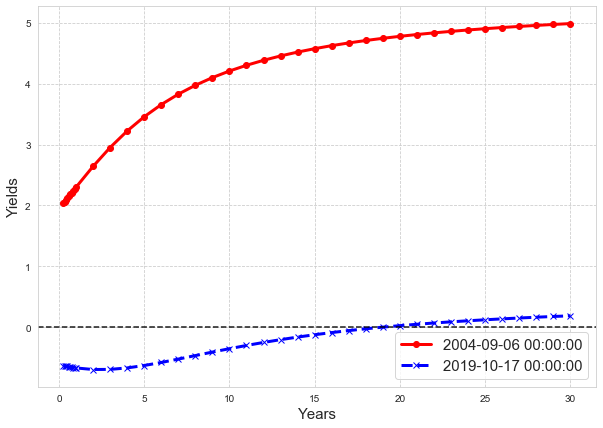

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(time_float,yields_df.iloc[0],linestyle='-',marker='o',color='r',lw=3,label='{}'.format(yields_df.index[0]))
ax.plot(time_float,yields_df.iloc[-1],linestyle='--',marker='x',color='b',lw=3,label='{}'.format(yields_df.index[-1]))
ax.grid(linestyle='--')
ax.legend(loc = 'lower right', frameon=True, fontsize=15)
ax.set_xlabel('Years', fontsize=15)
ax.axhline(y=0,ls='--',c='k',alpha=0.9)
ax.set_ylabel('Yields',  fontsize=15);

### 5. Remove the monthly maturities from the Dataset:

In [13]:
# The Monthly Yields are removed:
yields_df_nm = yields_df.drop(['Yield 3M','Yield 4M','Yield 5M','Yield 6M','Yield 7M','Yield 8M','Yield 9M','Yield 10M','Yield 11M'],axis=1)
# For the purpose of the first analysis I will use only the last two years of data:
yields_df_last2y=yields_df_nm.iloc[-3700:,:]
display(np.round(yields_df_last2y.head(3),3))
display(np.round(yields_df_last2y.tail(3),3))
# Describe a subset of the dataset:
np.round(yields_df_last2y[['Yield 1Y','Yield 3Y','Yield 5Y','Yield 7Y','Yield 10Y','Yield 15Y',
                      'Yield 20Y','Yield 25Y','Yield 30Y']].describe().T,3)

,Yield 1Y,Yield 2Y,Yield 3Y,Yield 4Y,Yield 5Y,Yield 6Y,Yield 7Y,Yield 8Y,Yield 9Y,Yield 10Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2005-05-02,2.083,2.230,2.410,2.599,2.782,2.952,3.104,3.239,3.358,3.460,...,3.991,4.012,4.030,4.047,4.062,4.075,4.088,4.100,4.110,4.120
2005-05-03,2.067,2.208,2.388,2.578,2.763,2.934,3.089,3.226,3.345,3.449,...,3.984,4.005,4.024,4.040,4.055,4.069,4.082,4.093,4.104,4.114
2005-05-04,2.077,2.225,2.409,2.604,2.791,2.965,3.121,3.259,3.379,3.483,...,4.015,4.035,4.053,4.070,4.085,4.098,4.111,4.122,4.132,4.142


,Yield 1Y,Yield 2Y,Yield 3Y,Yield 4Y,Yield 5Y,Yield 6Y,Yield 7Y,Yield 8Y,Yield 9Y,Yield 10Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2019-10-15,-0.680,-0.719,-0.728,-0.713,-0.68,-0.636,-0.584,-0.529,-0.474,-0.420,...,-0.023,-0.002,0.017,0.035,0.051,0.066,0.080,0.093,0.105,0.116
2019-10-16,-0.671,-0.700,-0.698,-0.672,-0.63,-0.577,-0.518,-0.458,-0.398,-0.341,...,0.070,0.092,0.111,0.129,0.146,0.161,0.175,0.188,0.201,0.212
2019-10-17,-0.670,-0.695,-0.694,-0.670,-0.63,-0.580,-0.524,-0.467,-0.409,-0.353,...,0.048,0.069,0.088,0.105,0.122,0.137,0.151,0.164,0.176,0.187


,count,mean,std,min,25%,50%,75%,max
Yield 1Y,3700.0,0.830,1.610,-0.908,-0.483,0.109,1.950,4.540
Yield 3Y,3700.0,1.127,1.623,-0.958,-0.378,0.511,2.299,4.738
Yield 5Y,3700.0,1.480,1.602,-0.919,-0.075,1.061,2.802,4.730
Yield 7Y,3700.0,1.812,1.577,-0.824,0.203,1.582,3.243,4.736
Yield 10Y,3700.0,2.200,1.545,-0.680,0.563,2.184,3.665,4.776
Yield 15Y,3700.0,2.570,1.506,-0.481,0.931,2.717,3.971,4.872
Yield 20Y,3700.0,2.727,1.469,-0.347,1.142,2.886,4.056,4.985
Yield 25Y,3700.0,2.780,1.434,-0.266,1.270,2.891,4.086,5.098
Yield 30Y,3700.0,2.787,1.404,-0.211,1.355,2.832,4.052,5.175


### 6. Perform the Augmented-DF test on the tenors of the YC:

In [14]:
# Create list of features names:
features_list = ['Yield %iY' %i for i in range(1,31)]
# Create Dictionary to store results:
unit_root_test = {}
# initiate the ADF test class:
sTest = StationarityTests(autolag='AIC',regression='c')
# iterate on features names and perform ADF test for unit root:
for name in features_list:
    pvalue=sTest.ADF_Stationarity_Test(yields_df_last2y[name].dropna(), printResults = False)
    unit_root_test[name]={'P-Value':pvalue, 'Is Stationary?':sTest.isStationary}

# Show results in a dataframe
unit_root_test_df = pd.DataFrame(unit_root_test).T
unit_root_test_df['P-Value'] = unit_root_test_df['P-Value'].map('{:,.3f}'.format).astype('float64')
display_side_by_side(np.round(unit_root_test_df.iloc[:15,:],4),np.round(unit_root_test_df.iloc[15:,:],4))

,P-Value,Is Stationary?
Yield 1Y,0.797,False
Yield 2Y,0.859,False
Yield 3Y,0.871,False
Yield 4Y,0.894,False
Yield 5Y,0.911,False
Yield 6Y,0.924,False
Yield 7Y,0.935,False
Yield 8Y,0.944,False
Yield 9Y,0.953,False
Yield 10Y,0.957,False


### 7. Set aside the last 100 obeservations as test enviorement to test future trained models:

Train Dataset shape - rows: 3599, columns: 30
Test Dataset shape - rows: 100, columns: 30
Train Dataset shape - Start: 2005-05-03 00:00:00, End: 2019-05-30 00:00:00
Test Dataset shape - rows: 100, columns: 30
2005-05-03 00:00:00 2019-10-17 00:00:00


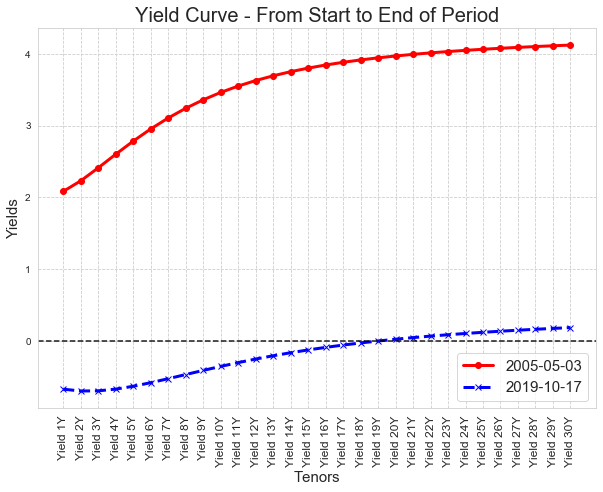

In [15]:
# Define the threshold between train and test set:
threshold=3599
# Divide the dataset in train and test set and then proceed to standarize data by using standard scaler:
# Split the dataset in train and test data: 80% Training and 20% Test
yields_df_last2y_d = yields_df_last2y.diff().dropna()
yields_train = yields_df_last2y_d.iloc[:threshold,:]
yields_test = yields_df_last2y_d.iloc[threshold:,:]

# fit a scaler on a training dataset:
scaler = StandardScaler(with_std=False)
scaler.fit(yields_train)
# transform train and test data using the traind transformer:
yields_df_train = scaler.transform(yields_train)
yields_df_test = scaler.transform(yields_test)
yields_df_l2 = scaler.transform(yields_df_last2y_d)
# Arrange the series in a DataFrame:
yields_df_train = pd.DataFrame(data=yields_df_train,index=yields_train.index,columns=yields_train.columns)
yields_df_test = pd.DataFrame(data=yields_df_test,index=yields_test.index,columns=yields_test.columns)
yields_df_l2 = pd.DataFrame(data=yields_df_l2,index=yields_df_last2y_d.index,columns=yields_df_last2y_d.columns)
# Print shapes of the two datasets:
print('Train Dataset shape - rows: {}, columns: {}'.format(yields_df_train.shape[0],yields_df_train.shape[1]))
print('Test Dataset shape - rows: {}, columns: {}'.format(yields_df_test.shape[0],yields_df_test.shape[1]))
print('Train Dataset shape - Start: {}, End: {}'.format(yields_df_train.index[0],yields_df_train.index[-1]))
print('Test Dataset shape - rows: {}, columns: {}'.format(yields_df_test.shape[0],yields_df_test.shape[1]))

train_start = yields_df_train.index[0]
train_end = yields_df_train.index[-1]
test_start = yields_df_test.index[0]
test_end = yields_df_test.index[-1]
print(train_start,test_end)

# Plot the dataset at the start and at the end of the training set:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(yields_df_last2y.iloc[0],linestyle='-',marker='o',color='r',lw=3, label='2005-05-03')
ax.plot(yields_df_last2y.iloc[-1],linestyle='--',marker='x',color='b',lw=3, label='2019-10-17')
ax.axhline(y=0,ls='--',c='k',alpha=0.9)
ax.grid(linestyle='--')
ax.legend(loc = 'lower right', frameon=True, fontsize=15)
ax.xaxis.set_tick_params(rotation=90,labelsize=12)
ax.set_xlabel('Tenors', fontsize=15)
ax.set_ylabel('Yields',  fontsize=15)
ax.set_title('Yield Curve - From Start to End of Period', fontsize=20);
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/Start_end_YC.png',dpi=75,bbox_inches='tight')

### 8. Remove the average from the data:

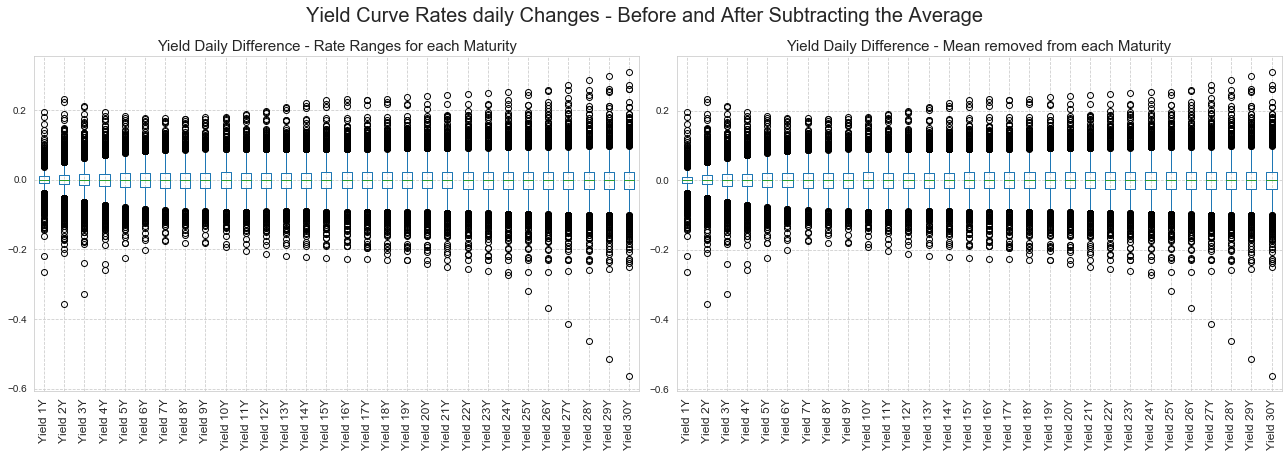

In [16]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

yields_df_last2y_d.plot.box(ax=ax[0])
ax[0].xaxis.set_tick_params(rotation=90,labelsize=12)
ax[0].grid(linestyle='--')
ax[0].set_title('Yield Daily Difference - Rate Ranges for each Maturity', fontsize=15);

yields_df_l2.plot.box(ax=ax[1])
ax[1].xaxis.set_tick_params(rotation=90,labelsize=12)
ax[1].grid(linestyle='--')
ax[1].set_title('Yield Daily Difference - Mean removed from each Maturity', fontsize=15);

fig.suptitle('Yield Curve Rates daily Changes - Before and After Subtracting the Average', fontsize=20, y=1.05)
plt.tight_layout()

# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/standardization.png',dpi=75,bbox_inches='tight')

In [17]:
# display head and tail of the 
display(yields_df_train.head())
display(yields_train.head())

,Yield 1Y,Yield 2Y,Yield 3Y,Yield 4Y,Yield 5Y,Yield 6Y,Yield 7Y,Yield 8Y,Yield 9Y,Yield 10Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2005-05-03,-0.015146,-0.020654,-0.021766,-0.020741,-0.018831,-0.016697,-0.014665,-0.012872,-0.011358,-0.010113,...,-0.005523,-0.005429,-0.005350,-0.005284,-0.005229,-0.005181,-0.005141,-0.005106,-0.005076,-0.005050
2005-05-04,0.010939,0.017411,0.022644,0.026673,0.029649,0.031757,0.033175,0.034065,0.034558,0.034760,...,0.031492,0.031166,0.030855,0.030561,0.030282,0.030019,0.029771,0.029536,0.029315,0.029106
2005-05-05,-0.004473,-0.008045,-0.010967,-0.012965,-0.014047,-0.014344,-0.014024,-0.013252,-0.012173,-0.010901,...,0.002261,0.003062,0.003803,0.004490,0.005126,0.005717,0.006266,0.006777,0.007254,0.007700
2005-05-06,0.012671,0.023759,0.029757,0.032584,0.033468,0.033192,0.032250,0.030955,0.029500,0.028004,...,0.016549,0.015959,0.015420,0.014926,0.014472,0.014054,0.013669,0.013313,0.012983,0.012676
2005-05-09,0.004296,0.008421,0.009904,0.009801,0.008782,0.007271,0.005533,0.003727,0.001949,0.000253,...,-0.011275,-0.011842,-0.012361,-0.012836,-0.013272,-0.013674,-0.014044,-0.014387,-0.014706,-0.015001


,Yield 1Y,Yield 2Y,Yield 3Y,Yield 4Y,Yield 5Y,Yield 6Y,Yield 7Y,Yield 8Y,Yield 9Y,Yield 10Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2005-05-03,-0.015898,-0.021456,-0.022615,-0.021631,-0.019752,-0.017642,-0.015627,-0.013846,-0.012341,-0.011102,...,-0.006514,-0.006418,-0.006339,-0.006271,-0.006215,-0.006166,-0.006125,-0.006089,-0.006058,-0.006031
2005-05-04,0.010186,0.016608,0.021794,0.025783,0.028728,0.030812,0.032213,0.033091,0.033575,0.033771,...,0.030502,0.030176,0.029867,0.029574,0.029296,0.029035,0.028787,0.028554,0.028333,0.028125
2005-05-05,-0.005225,-0.008847,-0.011817,-0.013855,-0.014968,-0.015288,-0.014986,-0.014227,-0.013156,-0.011889,...,0.001270,0.002072,0.002815,0.003502,0.004140,0.004732,0.005282,0.005795,0.006273,0.006719
2005-05-06,0.011919,0.022957,0.028907,0.031694,0.032547,0.032247,0.031288,0.029981,0.028517,0.027015,...,0.015558,0.014970,0.014432,0.013939,0.013486,0.013070,0.012685,0.012330,0.012001,0.011695
2005-05-09,0.003543,0.007618,0.009054,0.008911,0.007861,0.006327,0.004570,0.002752,0.000966,-0.000735,...,-0.012266,-0.012832,-0.013349,-0.013823,-0.014258,-0.014659,-0.015028,-0.015370,-0.015687,-0.015982


### 9. Visualize the time series of the Interest rates for bucket of maturities:

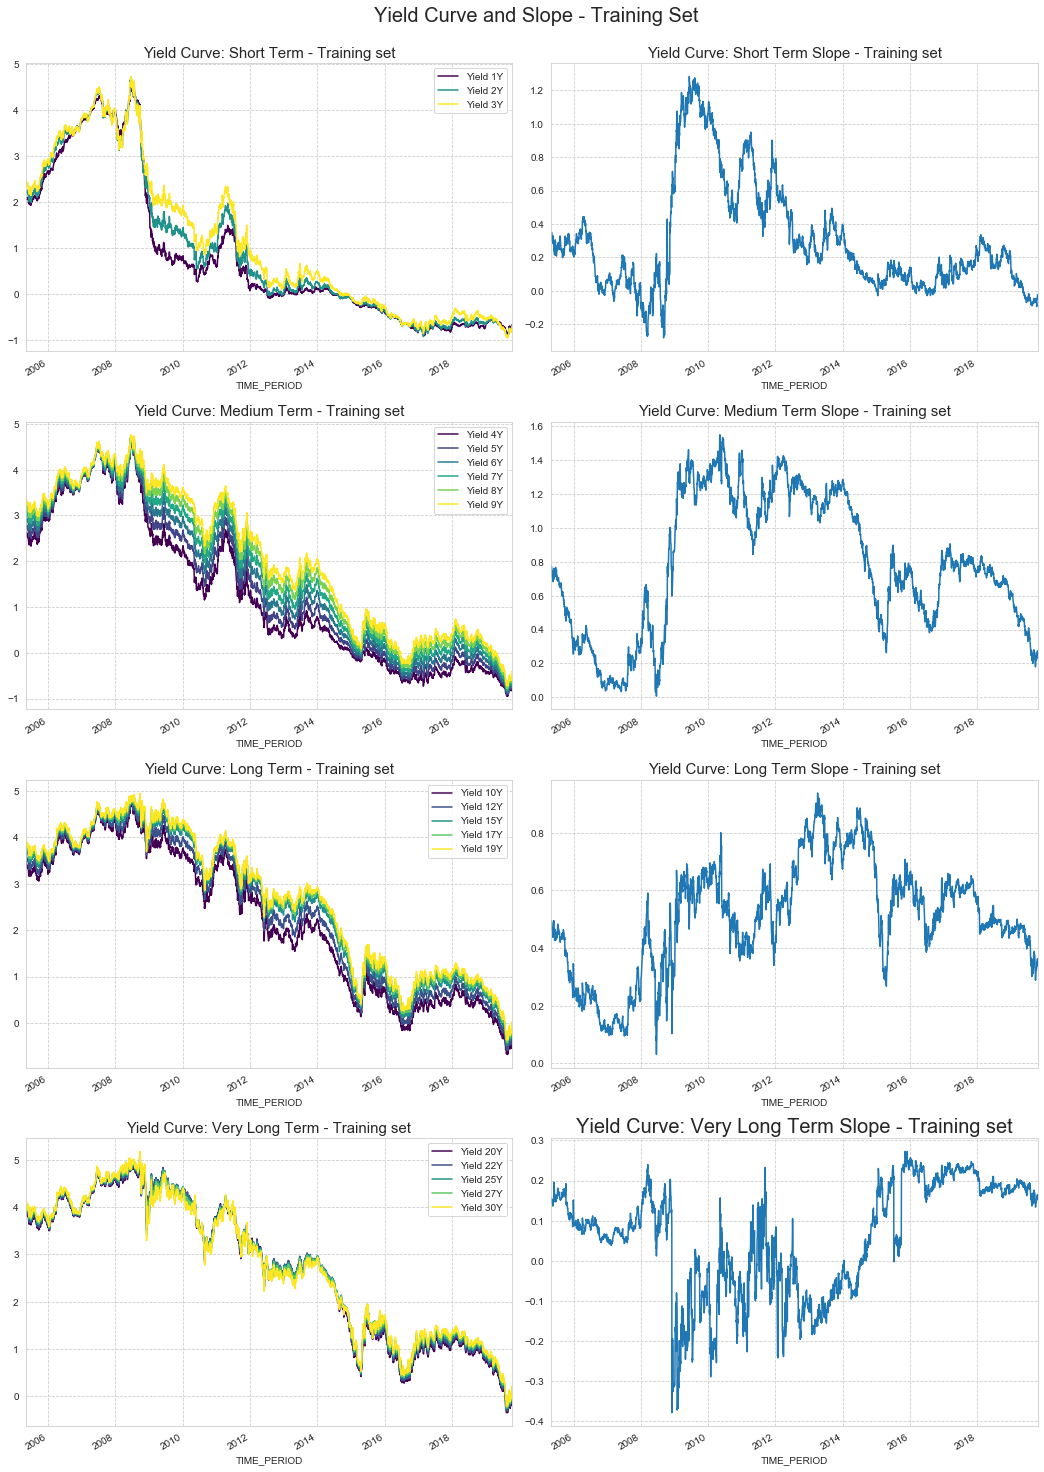

In [18]:
fig, ax = plt.subplots(4,2,figsize=(15,20))

ax=ax.ravel()

yields_df_last2y[['Yield 1Y','Yield 2Y','Yield 3Y']].plot(ax=ax[0],colormap='viridis')
ax[0].grid(linestyle='--')
ax[0].set_title('Yield Curve: Short Term - Training set', fontsize=15)

(yields_df_last2y['Yield 3Y']-yields_df_last2y['Yield 1Y']).plot(ax=ax[1])
ax[1].grid(linestyle='--')
ax[1].set_title('Yield Curve: Short Term Slope - Training set', fontsize=15);

yields_df_last2y[['Yield 4Y','Yield 5Y','Yield 6Y','Yield 7Y','Yield 8Y','Yield 9Y']].plot(ax=ax[2],colormap='viridis')
ax[2].grid(linestyle='--')
ax[2].set_title('Yield Curve: Medium Term - Training set', fontsize=15)

(yields_df_last2y['Yield 9Y']-yields_df_last2y['Yield 4Y']).plot(ax=ax[3])
ax[3].grid(linestyle='--')
ax[3].set_title('Yield Curve: Medium Term Slope - Training set', fontsize=15);

yields_df_last2y[['Yield 10Y','Yield 12Y','Yield 15Y','Yield 17Y','Yield 19Y']].plot(ax=ax[4],colormap='viridis')
ax[4].grid(linestyle='--')
ax[4].set_title('Yield Curve: Long Term - Training set', fontsize=15)

(yields_df_last2y['Yield 19Y']-yields_df_last2y['Yield 10Y']).plot(ax=ax[5])
ax[5].grid(linestyle='--')
ax[5].set_title('Yield Curve: Long Term Slope - Training set', fontsize=15);

yields_df_last2y[['Yield 20Y','Yield 22Y','Yield 25Y','Yield 27Y','Yield 30Y']].plot(ax=ax[6],colormap='viridis')
ax[6].grid(linestyle='--')
ax[6].set_title('Yield Curve: Very Long Term - Training set', fontsize=15)

(yields_df_last2y['Yield 30Y']-yields_df_last2y['Yield 20Y']).plot(ax=ax[7])
ax[7].grid(linestyle='--')
ax[7].set_title('Yield Curve: Very Long Term Slope - Training set', fontsize=20);

fig.suptitle('Yield Curve and Slope - Training Set', fontsize=20, y=1.02)

plt.tight_layout()
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/YC_bymaturities.png',dpi=75,bbox_inches='tight')

### 10. Compute the Correlation matrix and visualize in a heatmap:

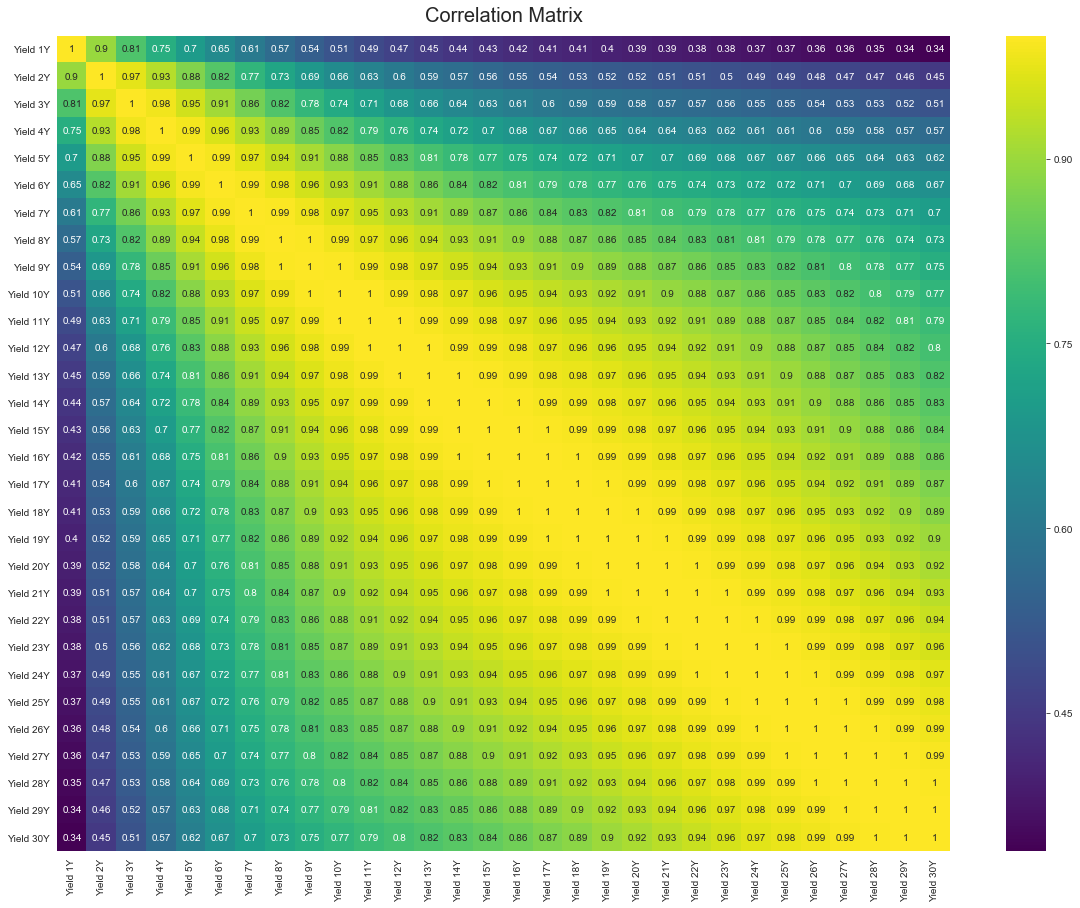

In [19]:
plt.figure(figsize=(20,15))
plt.title('Correlation Matrix', fontsize=20,y=1.01)
sns.heatmap(np.round(yields_df_train.corr(),3), annot=True, cmap="viridis");
#plt.tight_layout();
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/YC_corr_matrix.png',dpi=75,bbox_inches='tight')

### 11. Calculate the PC by applying the PCA

#### Scikit-Learn implementation of PCA:

In [20]:
# same calculation in Scikit-Learn:
yields_pca_skl = sck_dec.PCA(random_state=17).fit(yields_df_train)
yields_trans_sck = yields_pca_skl.transform(yields_df_train)
# Transform the entire dataset:
yields_trans_sck_all = yields_pca_skl.transform(yields_df_l2)
# Compare the PCA_1:
#pca_comp=pd.DataFrame(index=yields_df_train.index)
#pca_comp['yield_trans']=yields_trans[:,0].astype('float64')
#pca_comp['yield_trans_sck']=yields_trans_sck[:,0]
#print('Test if the two approaches deliver the same results for PC-1:',
#      (np.round(pca_comp['yield_trans_sck'],5)==np.round(pca_comp['yield_trans'],5)*(-1)).all())

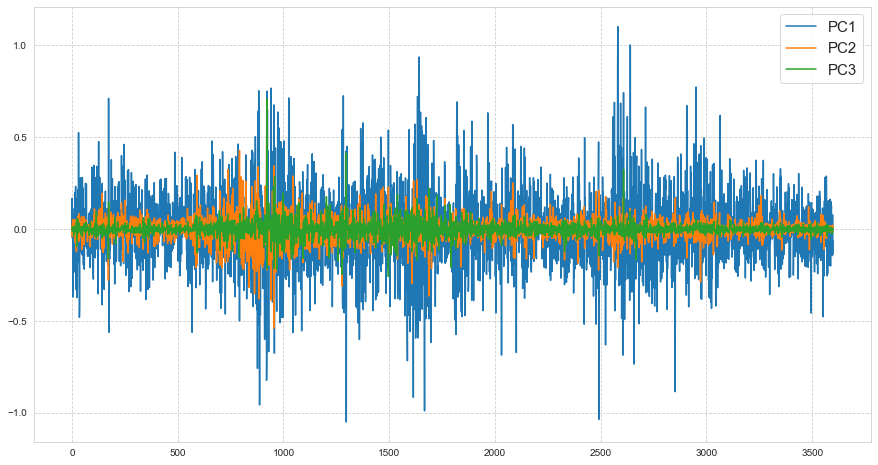

In [21]:
# Plot Principal Components:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(yields_trans_sck[:,0:3])
ax.grid(linestyle='--')
ax.legend(['PC1','PC2','PC3'],fontsize=15);

#### Store the results:

In [22]:
# Define PCs applied on all data:
pc_1=pd.Series(data=yields_trans_sck_all[:,0],index=yields_df_last2y_d.index)
pc_2=pd.Series(data=yields_trans_sck_all[:,1],index=yields_df_last2y_d.index)
pc_3=pd.Series(data=yields_trans_sck_all[:,2],index=yields_df_last2y_d.index)

### 12. Compare the PCs with the Interest rates

#### Compare Yields with PC_1,2 & 3:

In [23]:
# Add the PCs to the Yield Curve dataset:
pc1_yields = yields_df_train.copy()
pc1_yields['yields_PC1']=yields_trans_sck[:,0].astype('float64')
pc1_yields['yields_PC2']=yields_trans_sck[:,1].astype('float64')
pc1_yields['yields_PC3']=yields_trans_sck[:,2].astype('float64')

In [24]:
# Check the head:
pc1_yields.head()

,Yield 1Y,Yield 2Y,Yield 3Y,Yield 4Y,Yield 5Y,Yield 6Y,Yield 7Y,Yield 8Y,Yield 9Y,Yield 10Y,...,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y,yields_PC1,yields_PC2,yields_PC3
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2005-05-03,-0.015146,-0.020654,-0.021766,-0.020741,-0.018831,-0.016697,-0.014665,-0.012872,-0.011358,-0.010113,...,-0.005284,-0.005229,-0.005181,-0.005141,-0.005106,-0.005076,-0.005050,-0.046013,-0.036239,0.011193
2005-05-04,0.010939,0.017411,0.022644,0.026673,0.029649,0.031757,0.033175,0.034065,0.034558,0.034760,...,0.030561,0.030282,0.030019,0.029771,0.029536,0.029315,0.029106,0.167366,0.018454,0.012099
2005-05-05,-0.004473,-0.008045,-0.010967,-0.012965,-0.014047,-0.014344,-0.014024,-0.013252,-0.012173,-0.010901,...,0.004490,0.005126,0.005717,0.006266,0.006777,0.007254,0.007700,-0.012834,-0.040220,-0.012367
2005-05-06,0.012671,0.023759,0.029757,0.032584,0.033468,0.033192,0.032250,0.030955,0.029500,0.028004,...,0.014926,0.014472,0.014054,0.013669,0.013313,0.012983,0.012676,0.111952,0.051662,0.005768
2005-05-09,0.004296,0.008421,0.009904,0.009801,0.008782,0.007271,0.005533,0.003727,0.001949,0.000253,...,-0.012836,-0.013272,-0.013674,-0.014044,-0.014387,-0.014706,-0.015001,-0.032410,0.041338,0.001187


In [25]:
pc1_yields_red=pc1_yields.loc[:,['Yield 1Y','Yield 2Y','Yield 3Y','Yield 5Y','Yield 7Y','Yield 10Y','Yield 15Y','Yield 20Y','Yield 25Y','Yield 30Y','yields_PC1','yields_PC2','yields_PC3']]

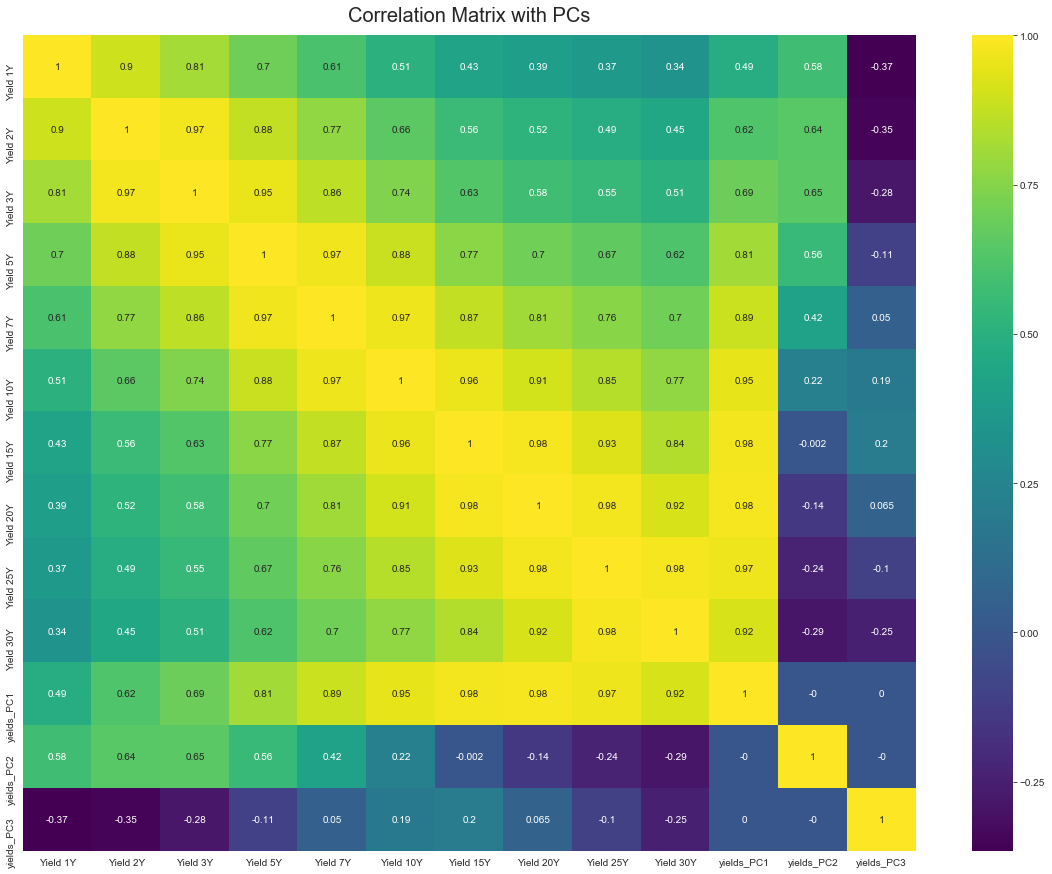

In [26]:
np.round(pc1_yields_red.corr(),3)

plt.figure(figsize=(20,15))
plt.title('Correlation Matrix with PCs', fontsize=20,y=1.01)
sns.heatmap(np.round(pc1_yields_red.corr(),3), annot=True, cmap="viridis");
#plt.tight_layout();
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/YC_corr_matrix_with_pcs.png',dpi=75,bbox_inches='tight')

### 13. Explained Variance of the PCs:

In [27]:
# Compute the Explained variance for each PCs
variance_explained=np.round(yields_pca_skl.explained_variance_ratio_,4)
variance_explained_cum = [np.sum(variance_explained[0:i+1]) for i in range(variance_explained.shape[0])]

# Create index and columns name for the Dataframe:
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8','PC_9']
index = ['variance_explained','variance_explained_cum']
# 
variance_analysis_df=pd.DataFrame(index=index,columns=columns)
variance_analysis_df.loc['variance_explained',:]=variance_explained[:9]
variance_analysis_df.loc['variance_explained_cum',:]=variance_explained_cum[:9]

In [28]:
display(variance_analysis_df.style.format("{:.2%}"))

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9
variance_explained,86.64%,9.12%,2.93%,0.96%,0.28%,0.06%,0.01%,0.00%,0.00%
variance_explained_cum,86.64%,95.76%,98.69%,99.65%,99.93%,99.99%,100.00%,100.00%,100.00%


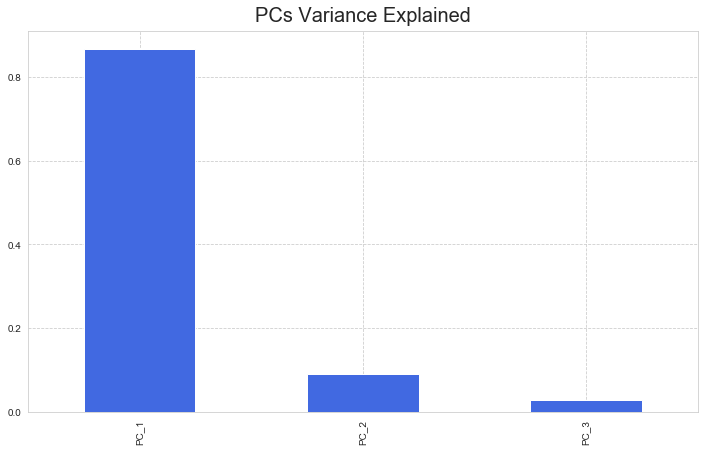

In [29]:
fig, ax = plt.subplots(figsize=(12,7))
variance_analysis_df.loc['variance_explained',['PC_1','PC_2','PC_3']].plot(kind='bar',ax=ax, color='royalblue')
#variance_analysis_df.loc['variance_explained_cum',['PC_1','PC_2','PC_3']].plot(kind='line',ax=ax,color='r');
ax.grid(linestyle='--')
ax.set_title('PCs Variance Explained', fontsize=20, y=1.01);
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/var_explained.png',dpi=75,bbox_inches='tight')

### Recovering the Original Daily variation from the first three PCs:

In [30]:
# Recalculate the entire yield using the first 3 PCs for a specific day:
yield_curve_pc_123 = np.dot(yields_trans_sck[-1,:3], yields_pca_skl.components_[0:3,:])
# Return the rates to their original scale:
yield_fc = scaler.inverse_transform(yield_curve_pc_123)

### Plotting the Eigenvectors:

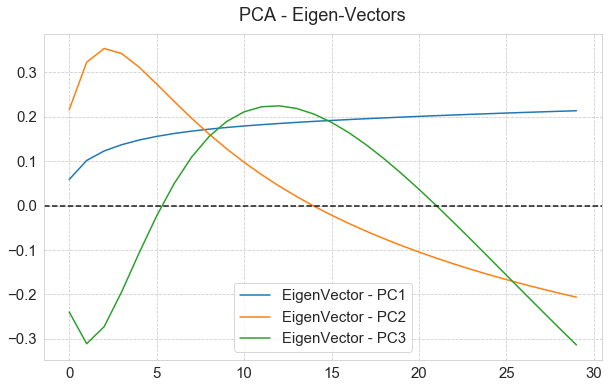

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(yields_pca_skl.components_[:3,:].T);
ax.grid(linestyle='--')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.axhline(y=0,ls='--',c='k',alpha=0.9)
ax.set_title('PCA - Eigen-Vectors', fontsize=18, y=1.02);
ax.legend(['EigenVector - PC1','EigenVector - PC2','EigenVector - PC3'],loc = 'lower center', frameon=True, fontsize=15)

# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/eigenvectors.png',dpi=75,bbox_inches='tight')

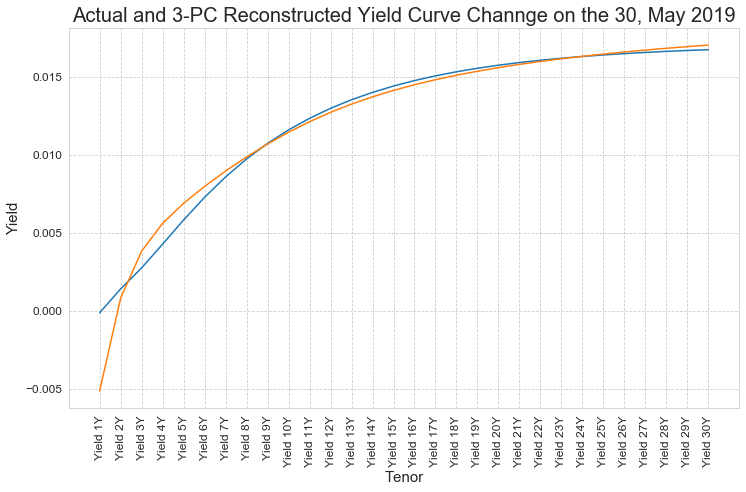

In [32]:
#store the date of the seleced day:
date=yields_train.index[-1]
#Plot the two Yield curves:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(yield_fc,label='Reconstructed Yield Curve')
ax.plot(yields_train.iloc[-1,:],label='Actual Yield Curve')
ax.xaxis.set_tick_params(rotation=90,labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.grid(linestyle='--')

ax.set_xlabel('Tenor', fontsize=15)
ax.set_ylabel('Yield', fontsize=15)
ax.set_title('Actual and 3-PC Reconstructed Yield Curve Channge on the {:%d, %b %Y}'.format(date), fontsize=20);

### Calculate PCs contribution to the daily change:

In [33]:
# Define the contribution of each PC:
YC_pc_123 = np.dot(yields_trans_sck[:,0:3], yields_pca_skl.components_[0:3,:])
# Return the rates to their original scale:
yield_reconstructed = scaler.inverse_transform(YC_pc_123)
# Define index and columns:
index_1=yields_df_train.index ; columns=yields_df_train.columns
# Create Dataframe:
yield_reconstructed_df=pd.DataFrame(data=yield_reconstructed,index=index_1,columns=columns)

In [34]:
# Define the contribution of each PC:
pc1_contribution = pd.DataFrame(np.dot(yields_trans_sck[:,0].reshape(-1,1), yields_pca_skl.components_[0,:].reshape(1,-1)),index=index_1,columns=yields_df_train.columns)
pc2_contribution = pd.DataFrame(np.dot(yields_trans_sck[:,1].reshape(-1,1), yields_pca_skl.components_[1,:].reshape(1,-1)),index=index_1,columns=yields_df_train.columns)
pc3_contribution = pd.DataFrame(np.dot(yields_trans_sck[:,2].reshape(-1,1), yields_pca_skl.components_[2,:].reshape(1,-1)),index=index_1,columns=yields_df_train.columns)

In [35]:
# Define the option in the dropdown menu:
options=[i.strftime('%Y-%m-%d') for i in index_1]

# Define the aftermath of selecting a specific date:
def f(selected):

    picked_date=selected
    fig, ax = plt.subplots(2,1,figsize=(15,16))
    # YC contributions Graph
    ax[0].plot(yields_train.loc[picked_date,:],label='Original Yield Curve')
    ax[0].plot(yield_reconstructed_df.loc[picked_date,:],label='Reconstructed Yield Curve')
    ax[0].set_ylabel('Yield', fontsize=15)
    ax[0].set_title('Actual vs PCA reconstructed Yield - {}'.format(picked_date), fontsize=25);
    # PC contributions Graph
    ax[1].plot(pc1_contribution.loc[picked_date,:],label='PC-1')
    ax[1].plot(pc2_contribution.loc[picked_date,:],label='PC-2')
    ax[1].plot(pc3_contribution.loc[picked_date,:],label='PC-3')
    ax[1].set_ylabel('PC', fontsize=15)
    ax[1].set_title('Principal Components - {}'.format(picked_date), fontsize=25);
    
    for i in range(2):
        ax[i].xaxis.set_tick_params(rotation=90,labelsize=12)
        ax[i].yaxis.set_tick_params(labelsize=12)
        ax[i].grid(linestyle='--')
        ax[i].legend(fontsize=15)
        ax[i].set_xlabel('Tenor', fontsize=15)
    
    plt.tight_layout()
    
# define interactive dropdown menu:
interact(f, selected=widgets.Dropdown(options=options,value='2018-03-06',description='Select Date:',disabled=False));

interactive(children=(Dropdown(description='Select Date:', index=3287, options=('2005-05-03', '2005-05-04', '2…

### 14. Information Loss Analysis:

#### Compute MSE, RMSE and MAE

In [36]:
# Compute some statistics on reconstructed yields for each segment of the Curve
# Create lists of columns of each dataframe
col_reconstructed=yield_reconstructed_df.columns
col_real=yields_train.columns
# Dictionary to store results:
results_yield_reconstructed={}
# iterate to compute the scores
for a in col_reconstructed:
    results_yield_reconstructed[a]={'MSE':mean_squared_error(yields_train.loc[:,a],yield_reconstructed_df.loc[:,a]),
                                    'RMSE':np.sqrt(mean_squared_error(yields_train.loc[:,a],yield_reconstructed_df.loc[:,a])),
                                    'MAE': mean_absolute_error(yields_train.loc[:,a],yield_reconstructed_df.loc[:,a])}
# Transform Dictionary in a DataFrame:    
results_yield_reconstructed_df=pd.DataFrame(results_yield_reconstructed).T
# Show the results splitting the dataframe in two parts:
print('Scores Achieved on Yields in Level:\n')
display_side_by_side(np.round(results_yield_reconstructed_df.iloc[:15,:],4),np.round(results_yield_reconstructed_df.iloc[15:,:],4))

Scores Achieved on Yields in Level:



,MSE,RMSE,MAE
Yield 1Y,0.0002,0.0133,0.0081
Yield 2Y,0.0001,0.0088,0.0049
Yield 3Y,0.0000,0.0049,0.0026
Yield 4Y,0.0000,0.0039,0.0022
Yield 5Y,0.0000,0.0048,0.0028
Yield 6Y,0.0000,0.0056,0.0033
Yield 7Y,0.0000,0.0058,0.0033
Yield 8Y,0.0000,0.0054,0.0030
Yield 9Y,0.0000,0.0047,0.0024
Yield 10Y,0.0000,0.0036,0.0018


#### Calculate MSE, RMSE and MAE as % of the total error for each metric:

In [37]:
a=results_yield_reconstructed_df.sum(axis=0)
results_yield_reconstructed_df_perc=results_yield_reconstructed_df.copy()

results_yield_reconstructed_df_perc.loc[:,'MSE']=results_yield_reconstructed_df.loc[:,'MSE'].div(a['MSE']).mul(100)
results_yield_reconstructed_df_perc.loc[:,'MAE']=results_yield_reconstructed_df.loc[:,'MAE'].div(a['MAE']).mul(100)
results_yield_reconstructed_df_perc.loc[:,'RMSE']=results_yield_reconstructed_df.loc[:,'RMSE'].div(a['RMSE']).mul(100)
display_side_by_side(np.round(results_yield_reconstructed_df_perc.iloc[:15,:],2),np.round(results_yield_reconstructed_df_perc.iloc[15:,:],2))

,MSE,RMSE,MAE
Yield 1Y,28.07,11.44,12.74
Yield 2Y,12.39,7.60,7.68
Yield 3Y,3.75,4.18,4.16
Yield 4Y,2.43,3.37,3.45
Yield 5Y,3.61,4.10,4.46
Yield 6Y,4.91,4.78,5.17
Yield 7Y,5.31,4.98,5.19
Yield 8Y,4.70,4.68,4.69
Yield 9Y,3.44,4.01,3.84
Yield 10Y,2.07,3.11,2.84


#### Calculate Information Loss by bucket of maturities:

In [38]:
inf_loss_buckets=pd.DataFrame(index=['1-5 Years','6-10 Years','11-15 Years','16-20 Years','21-25 Years','26-30 Years'],
                              columns = ['MSE','RMSE','MAE'])

inf_loss_buckets.loc['1-5 Years',:] = results_yield_reconstructed_df_perc.loc['Yield 1Y':'Yield 5Y',:].sum(axis=0)
inf_loss_buckets.loc['6-10 Years',:] = results_yield_reconstructed_df_perc.loc['Yield 6Y':'Yield 10Y',:].sum(axis=0)
inf_loss_buckets.loc['11-15 Years',:] = results_yield_reconstructed_df_perc.loc['Yield 11Y':'Yield 15Y',:].sum(axis=0)
inf_loss_buckets.loc['16-20 Years',:] = results_yield_reconstructed_df_perc.loc['Yield 16Y':'Yield 20Y',:].sum(axis=0)
inf_loss_buckets.loc['21-25 Years',:] = results_yield_reconstructed_df_perc.loc['Yield 21Y':'Yield 25Y',:].sum(axis=0)
inf_loss_buckets.loc['26-30 Years',:] = results_yield_reconstructed_df_perc.loc['Yield 26Y':'Yield 30Y',:].sum(axis=0)

display(np.round(inf_loss_buckets,2))

,MSE,RMSE,MAE
1-5 Years,50.2489,30.6859,32.4928
6-10 Years,20.4354,21.554,21.7141
11-15 Years,3.66798,9.00146,9.08705
16-20 Years,11.3023,16.2015,15.8761
21-25 Years,4.315,9.08722,7.93029
26-30 Years,10.0305,13.4699,12.8996


##### Plot error per Maturity as % of the total error:

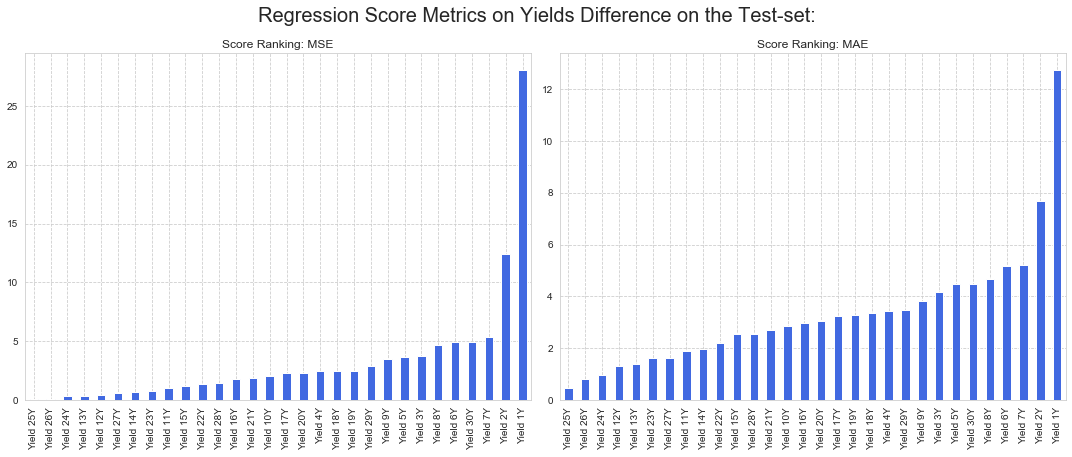

In [39]:
sorting = [('MSE', True), ('MAE', True)]

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax=ax.ravel()

for axes, a in enumerate(sorting):
    
    results_yield_reconstructed_df_perc.loc[:, a[0]].sort_values(ascending=a[1]).plot.bar(x='R2',color='royalblue', ax=ax[axes])
    ax[axes].grid(linestyle='--')
    ax[axes].set_title('Score Ranking: {}'.format(a[0]))
    
#fig.delaxes(ax[3])
fig.suptitle('Regression Score Metrics on Yields Difference on the Test-set:',fontsize=20,y=1.05);
plt.tight_layout()

### Compare Reconstructed and Actual daily Yield Changes:

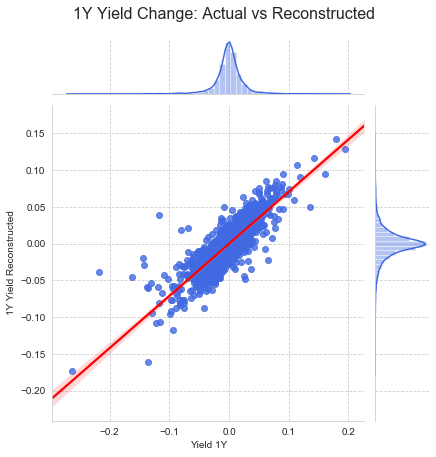

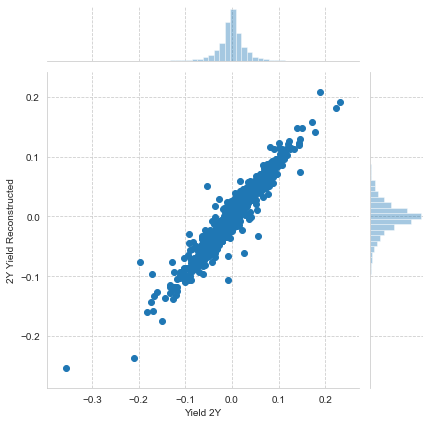

In [40]:
df_test_1y=pd.DataFrame(columns=['Yield 1Y','1Y Yield Reconstructed'])
df_test_2y=pd.DataFrame(columns=['Yield 2Y','2Y Yield Reconstructed'])
df_test_25y=pd.DataFrame(columns=['Yield 25Y','25Y Yield Reconstructed'])
df_test_1y['Yield 1Y']=yields_train['Yield 1Y']
df_test_1y['1Y Yield Reconstructed']=yield_reconstructed_df['Yield 1Y']
df_test_2y['Yield 2Y']=yields_train['Yield 2Y']
df_test_2y['2Y Yield Reconstructed']=yield_reconstructed_df['Yield 2Y']
df_test_25y['Yield 25Y']=yields_train['Yield 25Y']
df_test_25y['25Y Yield Reconstructed']=yield_reconstructed_df['Yield 25Y']


sns.jointplot(x='Yield 1Y', y='1Y Yield Reconstructed', data=df_test_1y, kind='reg',
              color='royalblue',joint_kws={'line_kws':{'color':'red'}});
plt.suptitle('1Y Yield Change: Actual vs Reconstructed', y = 1.05, fontsize = 16)

plt.show()

sns.jointplot(x='Yield 2Y', y='2Y Yield Reconstructed', data=df_test_2y);

In [41]:
df_test_1y.corr()

,Yield 1Y,1Y Yield Reconstructed
Yield 1Y,1.000000,0.841564
1Y Yield Reconstructed,0.841564,1.000000


#### Regression of the 1Y tenor on the reconstructed rate:

In [42]:
results = sm.OLS(100*df_test_1y['Yield 1Y'],sm.add_constant(100*df_test_1y['1Y Yield Reconstructed'])).fit()
print(results.summary())
df_test_1y.describe()

                            OLS Regression Results                            
Dep. Variable:               Yield 1Y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     8731.
Date:                Sat, 23 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:09:37   Log-Likelihood:                -6127.3
No. Observations:                3599   AIC:                         1.226e+04
Df Residuals:                    3597   BIC:                         1.227e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.73

,Yield 1Y,1Y Yield Reconstructed
count,3599.000000,3599.000000
mean,-0.000752,-0.000752
std,0.024586,0.020691
min,-0.263676,-0.172638
25%,-0.009647,-0.008971
50%,-0.000269,-0.000511
75%,0.009483,0.007969
max,0.194397,0.142050


##### Chek the results against Scikit learn results:

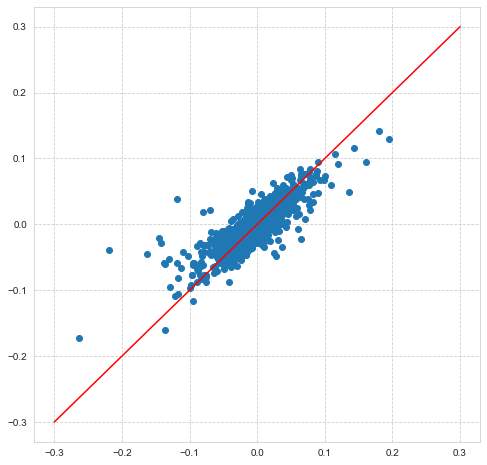

[9.75781955e-19] [[1.]]


0.7082301786890051

In [43]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(df_test_1y['Yield 1Y'],df_test_1y['1Y Yield Reconstructed'])

X_plot = np.linspace(-0.3,0.3,100)
ax.plot(X_plot, X_plot*results.params[1] + results.params[0], color='r')

plt.show()

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(df_test_1y['1Y Yield Reconstructed'].values.reshape(-1, 1),
                             df_test_1y['Yield 1Y'].values.reshape(-1, 1))
print(reg.intercept_,reg.coef_)
reg.score(df_test_1y['1Y Yield Reconstructed'].values.reshape(-1, 1),
          df_test_1y['Yield 1Y'].values.reshape(-1, 1))

#### Regression of the 25Y tenor on the reconstructed rate:

In [44]:
results_2 = sm.OLS(df_test_25y['Yield 25Y'],sm.add_constant(df_test_25y['25Y Yield Reconstructed'])).fit()
print(results_2.summary())
df_test_2y.describe()

                            OLS Regression Results                            
Dep. Variable:              Yield 25Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.587e+07
Date:                Sat, 23 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:09:38   Log-Likelihood:                 21261.
No. Observations:                3599   AIC:                        -4.252e+04
Df Residuals:                    3597   BIC:                        -4.251e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -3

,Yield 2Y,2Y Yield Reconstructed
count,3599.000000,3599.000000
mean,-0.000802,-0.000802
std,0.033184,0.031990
min,-0.356459,-0.252923
25%,-0.013377,-0.014289
50%,-0.000409,-0.000541
75%,0.012654,0.013423
max,0.231981,0.208099


### Testing for unit root in PCs:

In [45]:
# Create list of features names:
features_list = ['yields_PC%i' %i for i in range(1,4)]
# Create Dictionary to store results:
unit_root_test = {}
# initiate the ADF test class:
sTest = StationarityTests(autolag='AIC',regression='c')
# iterate on features names and perform ADF test for unit root:
for name in features_list:
    pvalue=sTest.ADF_Stationarity_Test(pc1_yields[name].dropna(), printResults = False)
    unit_root_test[name]={'P-Value':pvalue, 'Is Stationary?':sTest.isStationary}

# Show results in a dataframe
unit_root_test_df = pd.DataFrame(unit_root_test).T
unit_root_test_df['P-Value'] = unit_root_test_df['P-Value'].map('{:,.3f}'.format).astype('float64')
display(unit_root_test_df)

,P-Value,Is Stationary?
yields_PC1,0.0,True
yields_PC2,0.0,True
yields_PC3,0.0,True


### Plot Autocorrelation and Partial-Autocorrelation for each PC:

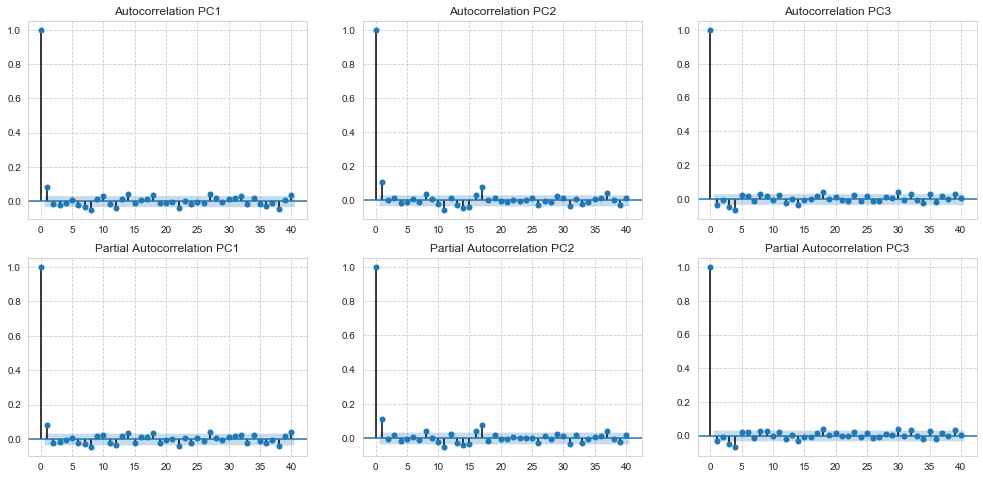

In [46]:
fig, ax = plt.subplots(2,3,figsize=(17,8))

ax=ax.ravel()

for num in range(len(features_list)):
    
    data=pc1_yields.loc[:,'yields_PC%i' %(num+1)].values

    sm.graphics.tsa.plot_acf(data, lags=40, ax=ax[num])
    sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax[num+3])
    ax[num].grid(linestyle='--')
    ax[num+3].grid(linestyle='--')
    
    ax[num].set_title('Autocorrelation PC{}'.format(num+1))
    ax[num+3].set_title('Partial Autocorrelation PC{}'.format(num+1))

#### Create a set of Empty dictionaries to store the results:

In [47]:
# Create dictionaries where to store the results:
pca_forecast = pd.DataFrame(index=yields_test.index,columns=['PC1_f','PC2_f','PC3_f'])
pca_forecast_lr = pd.DataFrame(index=yields_test.index,columns=['PC1_lr','PC2_lr','PC3_lr'])
pca_forecast_ur = pd.DataFrame(index=yields_test.index,columns=['PC1_ur','PC2_ur','PC3_ur'])
pca_forecast_insample = pd.DataFrame(index=yields_df_train.index,columns=['PC1_f','PC2_f','PC3_f'])
pca_insample_scores = {}
pca_insample_scores_d = {}
pca_forecast_scores = {}
pca_forecast_model = {}
pca_forecast.shape

(100, 3)

## 15. Explore PCA components:

## PC 1

### Preliminary Data Exploration:

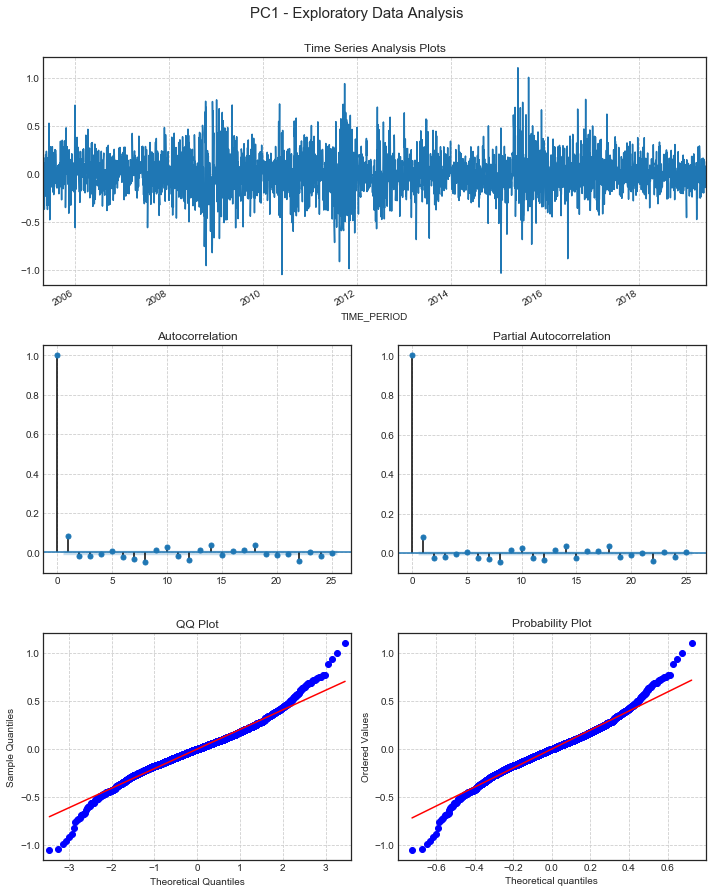

In [48]:
# Preliminary Data Exploration
pc_1_l=pc1_yields.loc[:,'yields_PC1']

_ = tsplot(pc_1_l,lags=25, title='PC1 - Exploratory Data Analysis', fontsize=15, figsize=(10, 12))

# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC1_ts_analysis.png',dpi=75,bbox_inches='tight')

### PC1 - Model Selection:

In [49]:
# define the Integration order based on the ADF test:
d1 = 1 if unit_root_test_df.loc['yields_PC1','Is Stationary?']==False else 0
# launch the auto-arima selector:
model_1 = pm.auto_arima(pc_1[1:threshold],start_p=0, start_q=0, max_p=6, max_q=6, d=d1, seasonal=False,
                     stepwise=True, suppress_warnings=True,information_criterion='bic',
                     error_action='ignore')

# print model's summury
print(model_1.summary())
# Print the model selected:
print('\n ARIMA Order: I: {}, ar: {}, ma: {}'.format(model_1.get_params()['order'][1],
                                                     model_1.get_params()['order'][0],
                                                     model_1.get_params()['order'][2]))
# define the ARIMA order:
order=(model_1.get_params()['order'][0],
       model_1.get_params()['order'][1],
       model_1.get_params()['order'][2])
# Store model features:
pca_forecast_model['PC_1 Model']={'AR':model_1.get_params()['order'][0],
                                  'I':model_1.get_params()['order'][1],
                                  'MA':model_1.get_params()['order'][2]}

# Initiate Arima Model:
Model_1_is=ARIMA(pc_1[:threshold],
                 order=order)
# Fit the ARIMA:
Model_1_fit = Model_1_is.fit(disp=0,suppress_warnings=True)

# In-sample prediction
if d1 ==1:
    preds_1=Model_1_fit.predict(dynamic=False,typ='levels')
    preds_1_l=Model_1_fit.predict(dynamic=False,typ='linear')
else:
    preds_1=Model_1_fit.predict(dynamic=False)
# Store the predicted PC-1
pca_forecast_insample['PC1_f']=preds_1

# Verify some error metrics - in sample on PC-1 in level:  
r2 = r2_score(pc_1[1:threshold],preds_1[1:threshold])
mse = mean_squared_error(pc_1[1:threshold],preds_1[1:threshold])
mae = mean_absolute_error(pc_1[1:threshold],preds_1[1:threshold])
# Store results:
pca_insample_scores['PC_1']={'R2':r2,'MSE':mse,'MAE':mae}
# Print the scores:
print('\nIn-sample Scores for PC-1 in Level: \nR2: {:.3f}, MSE: {:.3f}, MAE: {:.3f}'.format(r2,mse,mae))
if d1 ==1:

    # Verify some error metrics - in sample on PC-1 in difference:  
    r2_d = r2_score(pc_1[:threshold].diff().dropna(),preds_1_l)
    mse_d = mean_squared_error(pc_1[:threshold].diff().dropna(),preds_1_l)
    mae_d = mean_absolute_error(pc_1[:threshold].diff().dropna(),preds_1_l)
    # Store results:
    pca_insample_scores_d['PC_1']={'R2':r2_d,'MSE':mse_d,'MAE':mae_d}
    # Print the scores:
    print('\nIn-sample Scores for PC-1 in Difference: \nR2: {:.3f}, MSE: {:.3f}, MAE: {:.3f}'.format(r2_d,mse_d,mae_d))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3598
Model:                     ARMA(0, 1)   Log Likelihood                 622.858
Method:                       css-mle   S.D. of innovations              0.204
Date:                Sat, 23 Nov 2019   AIC                          -1239.717
Time:                        23:09:50   BIC                          -1221.152
Sample:                             0   HQIC                         -1233.101
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.889e-05      0.004      0.005      0.996      -0.007       0.007
ma.L1.y        0.0853      0.017      5.077      0.000       0.052       0.118
                                    Roots           

C:\Users\fabrizioxueling\Anaconda3\envs\all_new\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### PC1 - Residual Analysis:

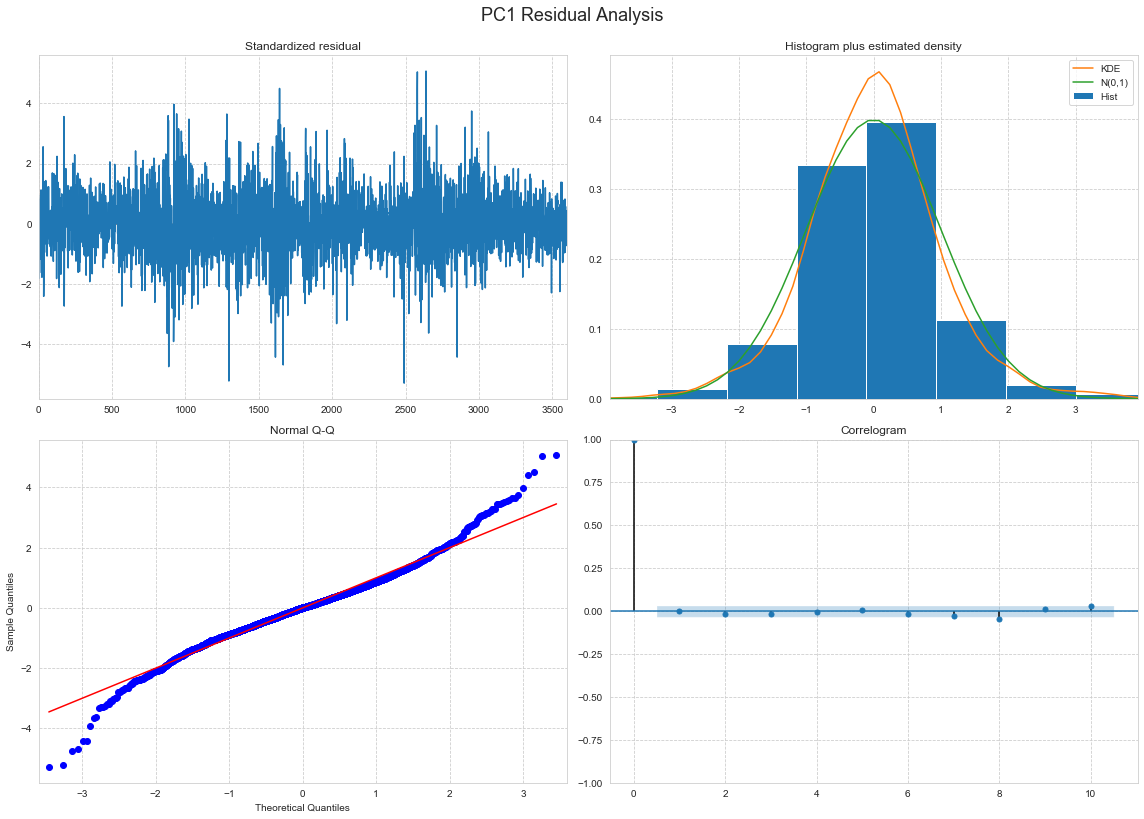

In [50]:
# Residual Diagnostic graph
fig=model_1.plot_diagnostics(figsize=(16,11))

fig.suptitle('PC1 Residual Analysis',fontsize=18,y=1.03)

for ax in fig.axes:
    ax.grid(linestyle='--')
    
plt.tight_layout()
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC1_arma_res.png',dpi=75,bbox_inches='tight')
plt.show()



### PC-1 Forecast - One-Step Ahead Recursive

In [51]:
warnings.filterwarnings('ignore')
# Create a list for  list into a pandas series:
preds_1_oos=[]
lower_series_1=[]
upper_series_1=[]

# Start the stepwise forecast:
#for i in tqdm_notebook(range(0,100)):
for i in range(0,100):
    Model_1 = ARIMA(pc_1[:threshold+i],
                    order=order)
    
    Model_1_fitted = Model_1.fit(disp=0,suppress_warnings=True)
    forecast = Model_1_fitted.forecast()

    preds_1_oos.append(forecast[0][0])
    lower_series_1.append(forecast[2][0,0])
    upper_series_1.append(forecast[2][0,1])     

    
# Transform the forecast list into a pandas series:
preds_1_oos_serie=pd.Series(data=preds_1_oos,index=yields_df_test.index)
lower_series_1_series=pd.Series(data=lower_series_1,index=yields_df_test.index)
upper_series_1_series=pd.Series(data=upper_series_1,index=yields_df_test.index)
# Store results in a dataframe:
pca_forecast.loc[:,'PC1_f']=preds_1_oos
pca_forecast_ur.loc[:,'PC1_ur']=upper_series_1_series
pca_forecast_lr.loc[:,'PC1_lr']=lower_series_1_series
# Verify some error metrics - in sample  
r2 = r2_score(pc_1[threshold:],preds_1_oos_serie)
rmse = np.sqrt(mean_squared_error(pc_1[threshold:],preds_1_oos_serie))
mae = mean_absolute_error(pc_1[threshold:],preds_1_oos_serie)
# Store the results:
pca_forecast_scores['PC_1']={'R2_f':r2,'RMSE_f':rmse,'MAE_f':mae}
# Print the scores:
print('Out-of-Sample Scores: \nR2: {:.2}, RMSE: {:.2}, MAE: {:.2}'.format(r2,rmse,mae))

Out-of-Sample Scores: 
R2: -0.025, RMSE: 0.2, MAE: 0.16


#### Plot 1-step ahead forecast:

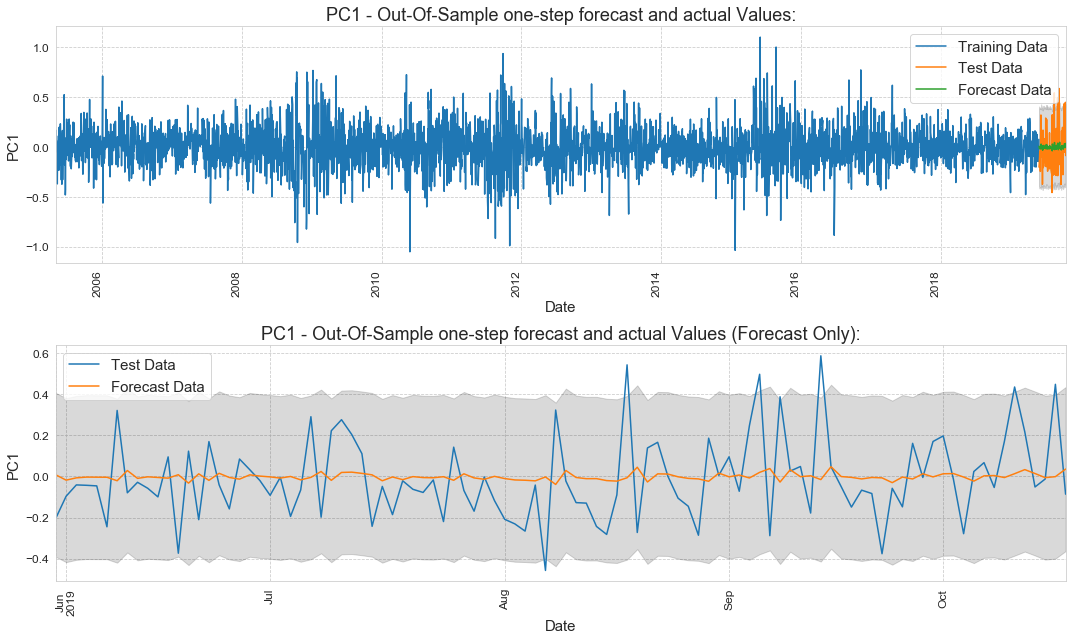

In [52]:
#Plot Forecast for PC_1
fig, ax = plt.subplots(2,1,figsize=(15,9))
# First Graph
pc_1[:threshold].plot(ax=ax[0],label='Training Data')
pc_1[threshold:].plot(ax=ax[0],label='Test Data')
preds_1_oos_serie.plot(ax=ax[0],label='Forecast Data')
# Second Graph
pc_1[threshold:].plot(ax=ax[1],label='Test Data')
preds_1_oos_serie.plot(ax=ax[1],label='Forecast Data')
#titles:
ax[0].set_title('PC1 - Out-Of-Sample one-step forecast and actual Values:',fontsize=18)
ax[1].set_title('PC1 - Out-Of-Sample one-step forecast and actual Values (Forecast Only):',fontsize=18)

for axes in ax:
    
    axes.fill_between(lower_series_1_series.index, lower_series_1_series, upper_series_1_series,color='k', alpha=.15)
    axes.xaxis.set_tick_params(rotation=90,labelsize=12)
    axes.yaxis.set_tick_params(labelsize=12)
    axes.grid(linestyle='--')
    axes.legend(fontsize=15)
    axes.set_xlabel('Date', fontsize=15)
    axes.set_ylabel('PC1', fontsize=15)

plt.tight_layout()
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC1_forecast.png',dpi=75,bbox_inches='tight')
plt.show()

### PC 2

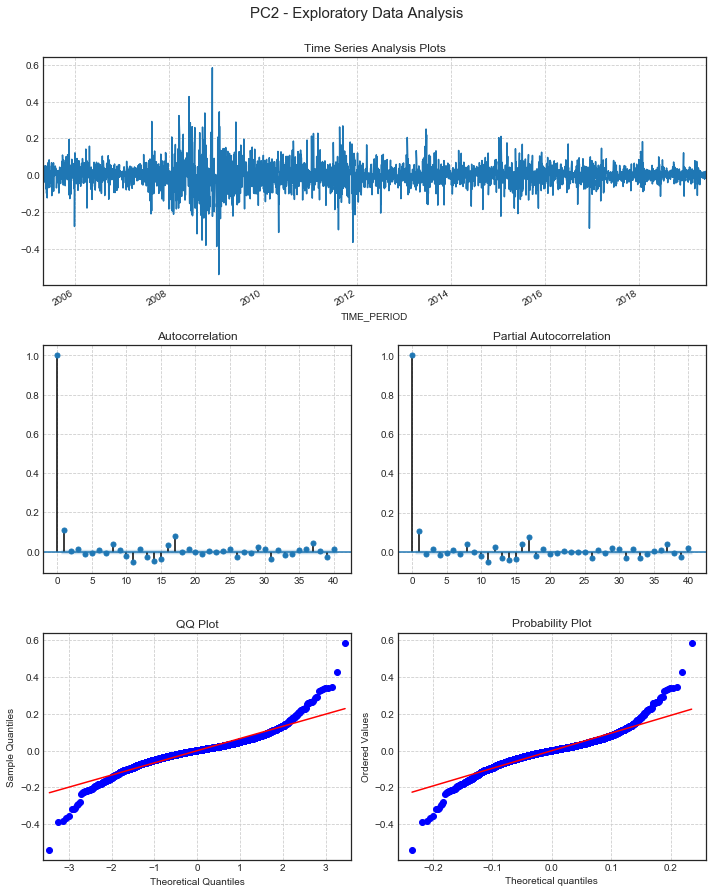

In [53]:
# Preliminary Data Exploration
pc_2_l=pc1_yields.loc[:,'yields_PC2']

_ = tsplot(pc_2_l,lags=40, title='PC2 - Exploratory Data Analysis',fontsize=15, figsize=(10, 12))

# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC2_ts_analysis.png',dpi=75,bbox_inches='tight')

### PC2 -  Model Selection and Fitting:

In [54]:
warnings.filterwarnings('ignore')
# define the Integration order based on the ADF test:
d2 = 1 if unit_root_test_df.loc['yields_PC2','Is Stationary?']==False else 0
# launch the auto-arima selector:
model_2 = pm.auto_arima(pc_2[:train_end],start_p=0, start_q=0, max_p=6, max_q=6, d=d2, seasonal=False,
                     stepwise=True, suppress_warnings=True,information_criterion='bic',
                     error_action='ignore')

# print model's summury
print(model_2.summary())
# Print the model selected:
print('\n ARIMA Order: I: {}, ar: {}, ma: {}'.format(model_2.get_params()['order'][1],
                                                     model_2.get_params()['order'][0],
                                                     model_2.get_params()['order'][2]))
# define the ARIMA order:
order=(model_2.get_params()['order'][0],
       model_2.get_params()['order'][1],
       model_2.get_params()['order'][2])
# Store model features:
pca_forecast_model['PC_2 Model']={'AR':model_2.get_params()['order'][0],
                                  'I':model_2.get_params()['order'][1],
                                  'MA':model_2.get_params()['order'][2]}

# Initiate Arima Model:
Model_2_is=ARIMA(pc_2[:train_end],
                 order=order)
# Fit the ARIMA:
Model_2_fit = Model_2_is.fit(disp=0,suppress_warnings=True)
# In-sample prediction
if d2==1:
    preds_2=Model_2_fit.predict(dynamic=False,typ='levels')
    preds_2_l=Model_2_fit.predict(dynamic=False,typ='linear')
else:
    preds_2=Model_2_fit.predict(dynamic=False)
    
# Store the predicted PC-1
pca_forecast_insample['PC2_f']=preds_2
        
# Verify some error metrics - in sample
if d2==1:
    r2 = r2_score(pc_2[1:threshold],preds_2)
    mse = mean_squared_error(pc_2[1:threshold],preds_2)
    mae = mean_absolute_error(pc_2[1:threshold],preds_2)
else:
    r2 = r2_score(pc_2[:threshold],preds_2)
    mse = mean_squared_error(pc_2[:threshold],preds_2)
    mae = mean_absolute_error(pc_2[:threshold],preds_2)        
# Store results:
pca_insample_scores['PC_2']={'R2':r2,'MSE':mse,'MAE':mae}
# Print the scores:
print('\nIn-sample Scores: \nR2: {:.2}, MSE: {:.2}, MAE: {:.2}'.format(r2,mse,mae))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3599
Model:                     ARMA(0, 1)   Log Likelihood                4682.802
Method:                       css-mle   S.D. of innovations              0.066
Date:                Sat, 23 Nov 2019   AIC                          -9359.605
Time:                        23:10:11   BIC                          -9341.040
Sample:                             0   HQIC                         -9352.989
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.647e-06      0.001     -0.001      0.999      -0.002       0.002
ma.L1.y        0.1092      0.017      6.571      0.000       0.077       0.142
                                    Roots           

#### PC2 - Diagnostics on Residuals:

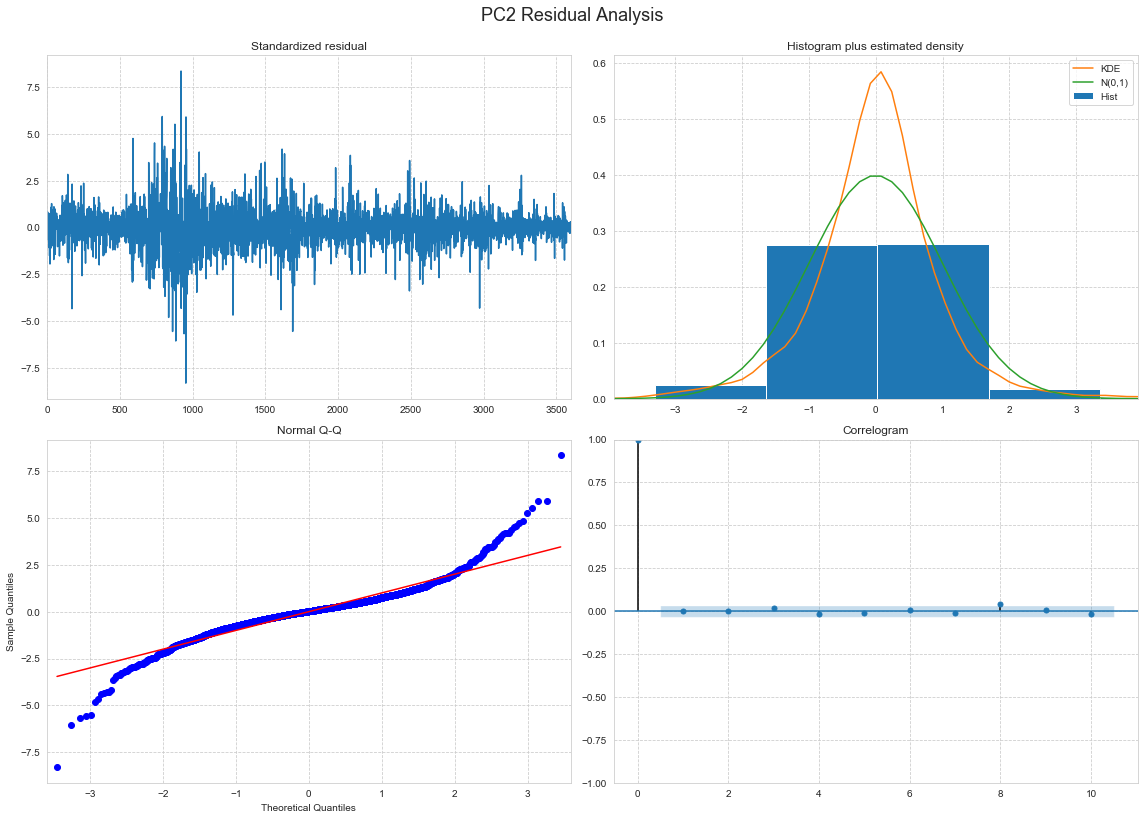

In [55]:
# Residual Diagnostic graph
fig=model_2.plot_diagnostics(figsize=(16,11))

fig.suptitle('PC2 Residual Analysis',fontsize=18,y=1.03)

for ax in fig.axes:
    ax.grid(linestyle='--')
    
plt.tight_layout()
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC2_arma_res.png',dpi=75,bbox_inches='tight')
plt.show()

#### PC2 - 1 step ahead forecast:

In [56]:
warnings.filterwarnings('ignore')
# Create a list for  list into a pandas series:
preds_2_oos = []
lower_series_2 = []
upper_series_2 = []
# Start the stepwise forecast:
#for i in tqdm_notebook(range(0,100)):
for i in range(0,100):
    
    Model_2 = ARIMA(pc_2[:threshold+i],
                    order=order)
    
    Model_2_fitted = Model_2.fit(disp=0,suppress_warnings=True)
    forecast = Model_2_fitted.forecast()
    preds_2_oos.append(forecast[0][0])
    lower_series_2.append(forecast[2][0,0])
    upper_series_2.append(forecast[2][0,1])  
    
# Transform the forecast list into a pandas series:
preds_2_oos_serie=pd.Series(data=preds_2_oos,index=yields_df_test.index)
lower_series_2_series=pd.Series(data=lower_series_2,index=yields_df_test.index)
upper_series_2_series=pd.Series(data=upper_series_2,index=yields_df_test.index)
# Store Results in a DataFrame
pca_forecast.loc[:,'PC2_f']=preds_2_oos
pca_forecast_ur.loc[:,'PC2_ur']=upper_series_2_series
pca_forecast_lr.loc[:,'PC2_lr']=lower_series_2_series
# Verify some error metrics - in sample  
r2 = r2_score(pc_2[threshold:],preds_2_oos_serie)
rmse = np.sqrt(mean_squared_error(pc_2[threshold:],preds_2_oos_serie))
mae = mean_absolute_error(pc_2[threshold:],preds_2_oos_serie)
# Store the results:
pca_forecast_scores['PC_2']={'R2_f':r2,'RMSE_f':rmse,'MAE_f':mae}
# Print the scores:
print('Out-of-Sample Scores: \nR2: {:.2}, MSE: {:.2}, MAE: {:.2}'.format(r2,rmse,mae))

Out-of-Sample Scores: 
R2: -0.048, MSE: 0.054, MAE: 0.04


#### Compare PC1 and PC2 one step ahead Forecast:

In [57]:
pd.DataFrame(pca_forecast_scores)

,PC_1,PC_2
R2_f,-0.025115,-0.047832
RMSE_f,0.204961,0.053815
MAE_f,0.157500,0.040005


#### PC2 - 1 step ahead forecast graph:

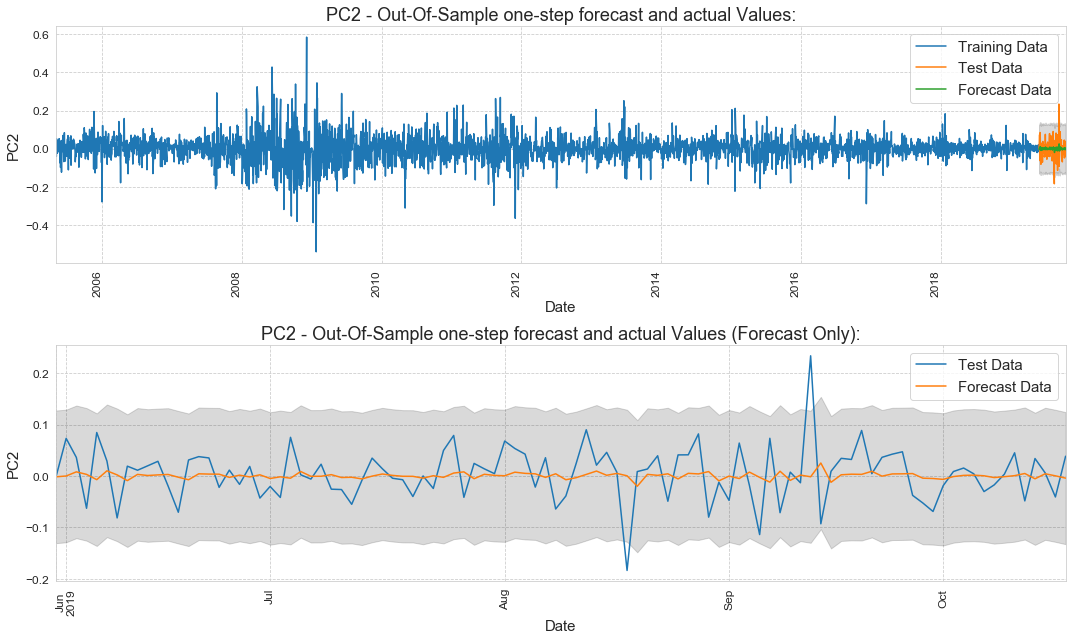

In [58]:
#Plot Forecast for PC_2
fig, ax = plt.subplots(2,1,figsize=(15,9))
# First Graph
pc_2[:threshold].plot(ax=ax[0],label='Training Data')
pc_2[threshold:].plot(ax=ax[0],label='Test Data')
preds_2_oos_serie.plot(ax=ax[0],label='Forecast Data')
# Second Graph
pc_2[threshold:].plot(ax=ax[1],label='Test Data')
preds_2_oos_serie.plot(ax=ax[1],label='Forecast Data')
#titles:
ax[0].set_title('PC2 - Out-Of-Sample one-step forecast and actual Values:',fontsize=18)
ax[1].set_title('PC2 - Out-Of-Sample one-step forecast and actual Values (Forecast Only):',fontsize=18)

for axes in ax:
    
    axes.fill_between(lower_series_2_series.index, lower_series_2_series, upper_series_2_series,color='k', alpha=.15)
    axes.xaxis.set_tick_params(rotation=90,labelsize=12)
    axes.yaxis.set_tick_params(labelsize=12)
    axes.grid(linestyle='--')
    axes.legend(fontsize=15)
    axes.set_xlabel('Date', fontsize=15)
    axes.set_ylabel('PC2', fontsize=15)

plt.tight_layout()
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC2_forecast.png',dpi=75,bbox_inches='tight')
plt.show()

### PC 3

#### Preliminary Data Exploration

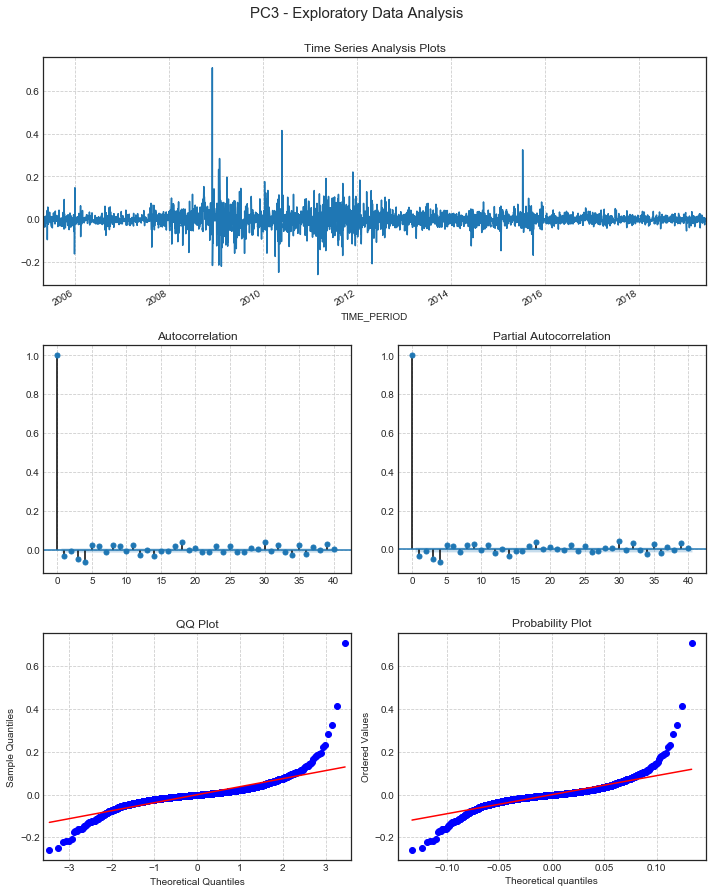

In [59]:
# Preliminary Data Exploration
pc_3_l=pc1_yields.loc[:,'yields_PC3']

_ = tsplot(pc_3_l,lags=40, title='PC3 - Exploratory Data Analysis',fontsize=15, figsize=(10, 12))

# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC3_ts_analysis.png',dpi=75,bbox_inches='tight')

#### PC3 - Model Selection:

In [60]:
warnings.filterwarnings('ignore')
# define the Integration order based on the ADF test:
d3 = 1 if unit_root_test_df.loc['yields_PC3','Is Stationary?']==False else 0
# launch the auto-arima selector:
model_3 = pm.auto_arima(pc_3[:train_end],start_p=0, start_q=0, max_p=6, max_q=6, d=d3, seasonal=False,
                     stepwise=True, suppress_warnings=True,information_criterion='bic',
                     error_action='ignore')

# print model's summury
print(model_3.summary())
# Print the model selected:
print('\n ARIMA Order: I: {}, ar: {}, ma: {}'.format(model_3.get_params()['order'][1],
                                                     model_3.get_params()['order'][0],
                                                     model_3.get_params()['order'][2]))
# define the ARIMA order:
order=(model_3.get_params()['order'][0],
       model_3.get_params()['order'][1],
       model_3.get_params()['order'][2])
# Store model features:
pca_forecast_model['PC_3 Model']={'AR':model_3.get_params()['order'][0],
                                  'I':model_3.get_params()['order'][1],
                                  'MA':model_3.get_params()['order'][2]}

# Initiate Arima Model:
Model_3_is=ARIMA(pc_3[:train_end],
              order=order)
# Fit the ARIMA:
Model_3_fit = Model_3_is.fit(disp=0,suppress_warnings=True)

# In-sample prediction
if d3==1:
    preds_3=Model_3_fit.predict(dynamic=False,typ='levels')
    preds_3_l=Model_3_fit.predict(dynamic=False,typ='linear')
else:
    preds_3=Model_3_fit.predict(dynamic=False)

# Store the predicted PC-1
pca_forecast_insample['PC3_f']=preds_3
# Verify some error metrics - in sample  
r2 = r2_score(pc_3[:threshold],preds_3)
mse = mean_squared_error(pc_3[:threshold],preds_3)
mae = mean_absolute_error(pc_3[:threshold],preds_3)
# Store results:
pca_insample_scores['PC_3']={'R2':r2,'MSE':mse,'MAE':mae}
# Print the scores:
print('\nIn-sample Scores: \nR2: {:.2}, MSE: {:.2}, MAE: {:.2}'.format(r2,mse,mae))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3599
Model:                     ARMA(0, 0)   Log Likelihood                6706.933
Method:                           css   S.D. of innovations              0.038
Date:                Sat, 23 Nov 2019   AIC                         -13409.866
Time:                        23:10:34   BIC                         -13397.489
Sample:                             0   HQIC                        -13405.455
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.523e-10      0.001   -1.2e-06      1.000      -0.001       0.001

 ARIMA Order: I: 0, ar: 0, ma: 0

In-sample Scores: 
R2: -4.4e-16, MSE: 0.0014, MAE: 0.022


In [61]:
np.round(pd.DataFrame(pca_insample_scores),3)

,PC_1,PC_2,PC_3
R2,0.007,0.012,-0.000
MSE,0.041,0.004,0.001
MAE,0.152,0.045,0.022


#### PC3 - Diagnostics on Residuals:

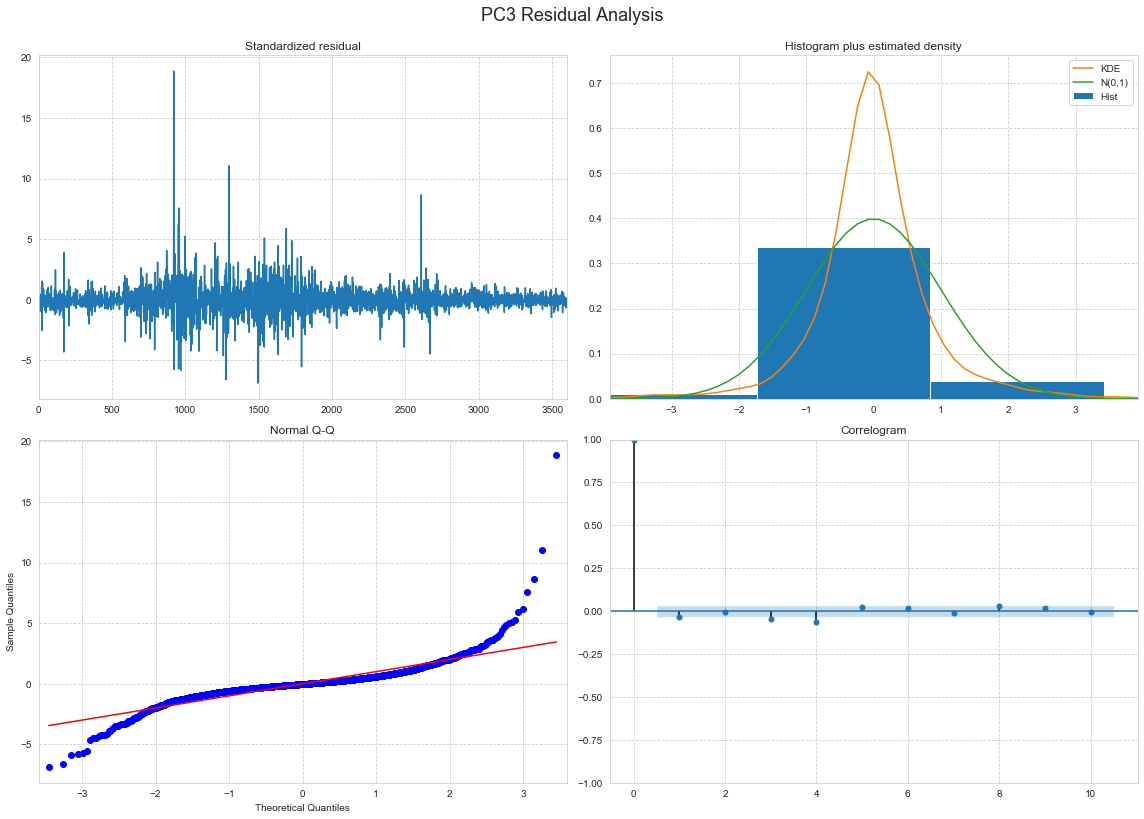

In [62]:
# Residual Diagnostic graph
fig=model_3.plot_diagnostics(figsize=(16,11))

fig.suptitle('PC3 Residual Analysis',fontsize=18,y=1.03)

for ax in fig.axes:
    ax.grid(linestyle='--')
    
plt.tight_layout()

# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC3_arma_res.png',dpi=75,bbox_inches='tight')
plt.show()

#### PC3 - 1 step ahead Forecast:

In [63]:
warnings.filterwarnings('ignore')
#from tqdm import tqdm_notebook

# Create a list for  list into a pandas series:
preds_3_oos=[]
lower_series_3 = []
upper_series_3 = []
order_progression={}
# Start the stepwise forecast:
for i in range(0,100):
      
    Model_3 = ARIMA(pc_3[:threshold+i],
                    order=order)
    
    Model_3_fitted = Model_3.fit(disp=0,suppress_warnings=True)
    forecast = Model_3_fitted.forecast()
    preds_3_oos.append(forecast[0][0])
    lower_series_3.append(forecast[2][0,0])
    upper_series_3.append(forecast[2][0,1])  
    
    
# Transform the forecast list into a pandas series:
preds_3_oos_serie=pd.Series(data=preds_3_oos,index=yields_df_test.index)
lower_series_3_series=pd.Series(data=lower_series_3,index=yields_df_test.index)
upper_series_3_series=pd.Series(data=upper_series_3,index=yields_df_test.index)
# Store Results in a DataFrame
pca_forecast.loc[:,'PC3_f']=preds_3_oos
pca_forecast_ur.loc[:,'PC3_ur']=upper_series_3_series
pca_forecast_lr.loc[:,'PC3_lr']=lower_series_3_series
# Verify some error metrics - in sample  
r2 = r2_score(pc_3[threshold:],preds_3_oos_serie)
mse = mean_squared_error(pc_3[threshold:],preds_3_oos_serie)
mae = mean_absolute_error(pc_3[threshold:],preds_3_oos_serie)
# Store the results:
pca_forecast_scores['PC_3']={'R2_f':r2,'MSE_f':mse,'MAE_f':mae}
# Print the scores:
print('Out-of-Sample Scores: \nR2: {:.2}, MSE: {:.2}, MAE: {:.2}'.format(r2,mse,mae))

Out-of-Sample Scores: 
R2: -0.0033, MSE: 0.00023, MAE: 0.012


#### PC3 - 1 step ahead forecast plot:

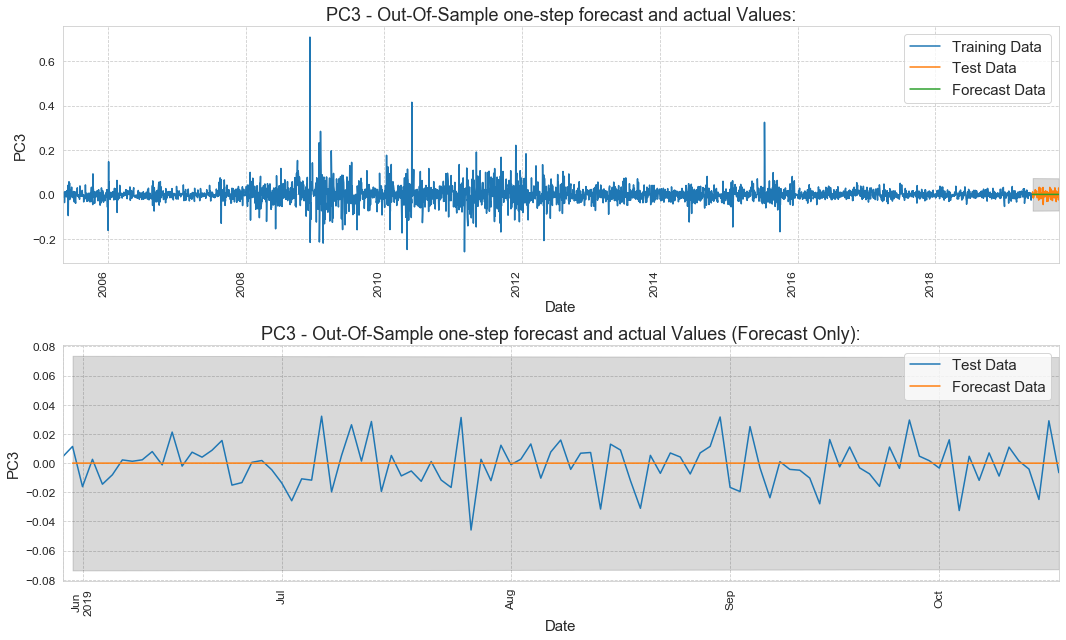

In [64]:
#Plot Forecast for PC_3
fig, ax = plt.subplots(2,1,figsize=(15,9))
# First Graph
pc_3[:train_end].plot(ax=ax[0],label='Training Data')
pc_3[train_end:].plot(ax=ax[0],label='Test Data')
preds_3_oos_serie.plot(ax=ax[0],label='Forecast Data')
# Second Graph
pc_3[train_end:].plot(ax=ax[1],label='Test Data')
preds_3_oos_serie.plot(ax=ax[1],label='Forecast Data')
#titles:
ax[0].set_title('PC3 - Out-Of-Sample one-step forecast and actual Values:',fontsize=18)
ax[1].set_title('PC3 - Out-Of-Sample one-step forecast and actual Values (Forecast Only):',fontsize=18)

for axes in ax:
    
    axes.fill_between(lower_series_3_series.index, lower_series_3_series, upper_series_3_series,color='k', alpha=.15)
    axes.xaxis.set_tick_params(rotation=90,labelsize=12)
    axes.yaxis.set_tick_params(labelsize=12)
    axes.grid(linestyle='--')
    axes.legend(fontsize=15)
    axes.set_xlabel('Date', fontsize=15)
    axes.set_ylabel('PC3', fontsize=15)

plt.tight_layout()
plt.show()

## 16. Testing for Heteroskedasticity:

### - PC1 White-Test

In [65]:
# Get residuals:
resid_pc1=model_1.resid()
# Create a DataFrame with the residuals:
whitetest_data = pd.DataFrame(model_1.resid(),columns=['resid'])
whitetest_data['resid2'] = whitetest_data['resid'] #**2
whitetest_data['resid2'] = whitetest_data['resid2'].shift()
whitetest_data.dropna(inplace=True)

white_test = het_white(whitetest_data['resid'], exog=sm.add_constant(whitetest_data['resid2']))

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

white_df_pc1=pd.DataFrame.from_dict(dict(zip(labels, white_test)),orient='index',columns=['Stats - PC1'])
display(np.round(white_df_pc1,2))

,Stats - PC1
LM Statistic,86.96
LM-Test p-value,0.00
F-Statistic,44.52
F-Test p-value,0.00


### - PC2 White-Test

In [66]:
# Get residuals:
resid_pc2=model_2.resid()
# Create a DataFrame with the residuals:
whitetest_data_2 = pd.DataFrame(model_2.resid(),columns=['resid'])
whitetest_data_2['resid2'] = whitetest_data_2['resid'].shift()
#whitetest_data['resid2'] = whitetest_data['resid2']
whitetest_data_2.dropna(inplace=True)

white_test_2 = het_white(whitetest_data_2['resid'], exog=sm.add_constant(whitetest_data_2['resid2']))

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

white_df_pc2=pd.DataFrame.from_dict(dict(zip(labels, white_test_2)),orient='index',columns=['Stats - PC2'])
display(np.round(white_df_pc2,2))

,Stats - PC2
LM Statistic,438.13
LM-Test p-value,0.00
F-Statistic,249.23
F-Test p-value,0.00


### - PC3 White-Test

In [67]:
# Get residuals:
resid_pc3=model_3.resid()
# Create a DataFrame with the residuals:
whitetest_data_3 = pd.DataFrame(model_3.resid(),columns=['resid'])
whitetest_data_3['resid2'] = whitetest_data_3['resid'].shift()
#whitetest_data['resid2'] = whitetest_data['resid2']
whitetest_data_3.dropna(inplace=True)

white_test_3 = het_white(whitetest_data_3['resid'], exog=sm.add_constant(whitetest_data_3['resid2']))

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

white_df_pc3=pd.DataFrame.from_dict(dict(zip(labels, white_test_3)),orient='index',columns=['Stats - PC3'])
display(np.round(white_df_pc3,2))

,Stats - PC3
LM Statistic,37.56
LM-Test p-value,0.00
F-Statistic,18.96
F-Test p-value,0.00


### Merge the Results Datasets:

In [68]:
result_wt = pd.concat([white_df_pc1, white_df_pc2, white_df_pc3], axis=1, sort=False)
display(np.round(result_wt,2))

,Stats - PC1,Stats - PC2,Stats - PC3
LM Statistic,86.96,438.13,37.56
LM-Test p-value,0.00,0.00,0.00
F-Statistic,44.52,249.23,18.96
F-Test p-value,0.00,0.00,0.00


### 16.1 EDA on Squared Residual:

#### PC1 squared residual EDA

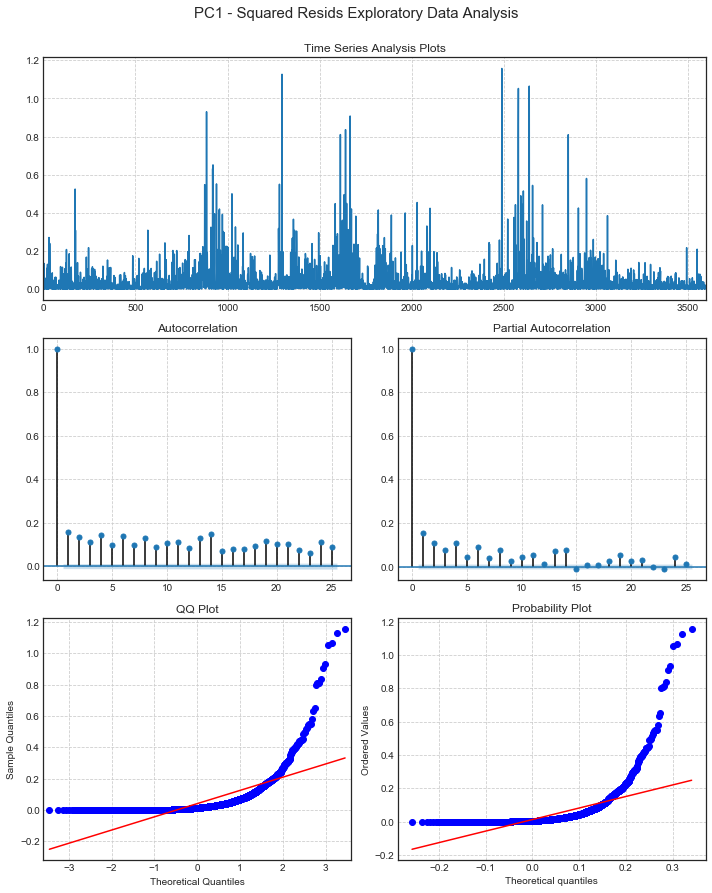

In [69]:
# Preliminary Data Exploration
resid_pc1_squared = resid_pc1 ** 2

_ = tsplot(resid_pc1_squared,lags=25, title='PC1 - Squared Resids Exploratory Data Analysis', fontsize=15, figsize=(10, 12))

# To save the figure activate the line below and replace the correct path
# plt.savefig('Pictures/PC1_resid_analysis.png',dpi=75,bbox_inches='tight')

#### PC2 squared residual EDA

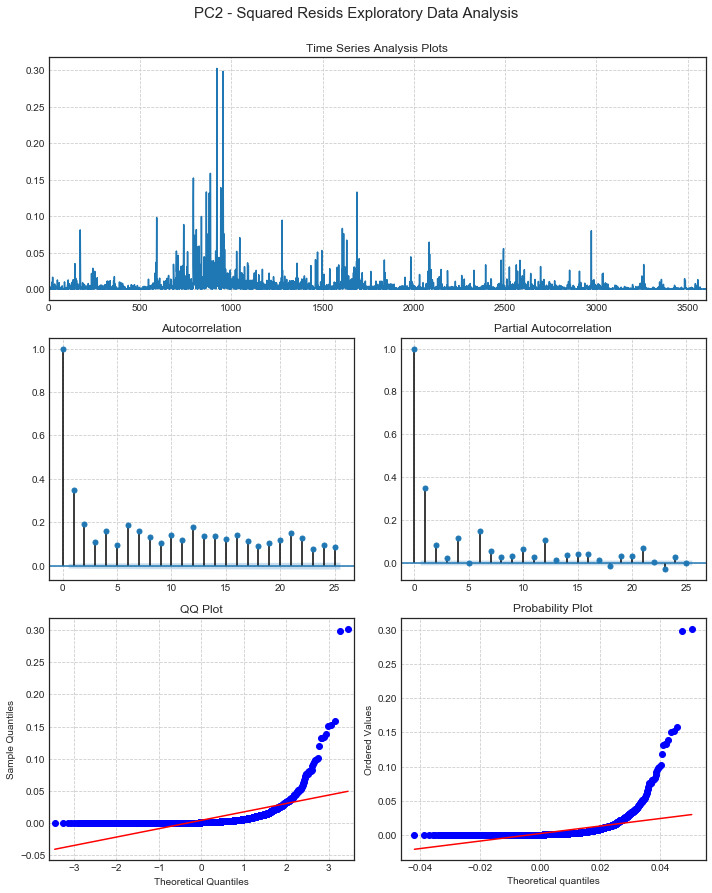

In [70]:
# Preliminary Data Exploration
resid_pc2_squared = resid_pc2 ** 2

_ = tsplot(resid_pc2_squared,lags=25, title='PC2 - Squared Resids Exploratory Data Analysis', fontsize=15, figsize=(10, 12))

# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC2_resid_analysis.png',dpi=75,bbox_inches='tight')

#### PC3 squared residual EDA

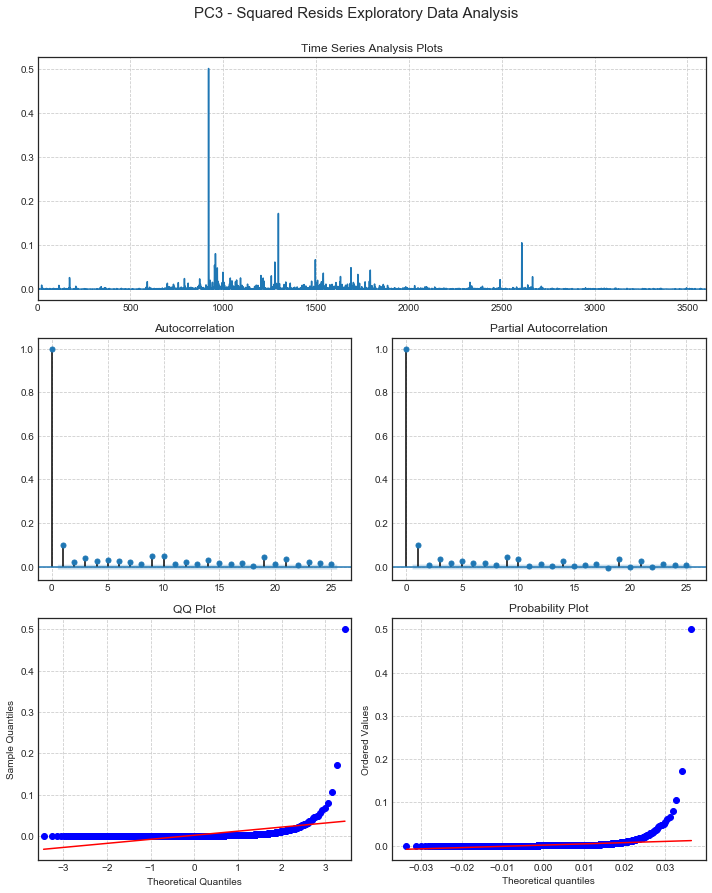

In [71]:
# Preliminary Data Exploration
resid_pc3_squared = resid_pc3 ** 2

_ = tsplot(resid_pc3_squared,lags=25, title='PC3 - Squared Resids Exploratory Data Analysis', fontsize=15, figsize=(10, 12))

# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/PC3_resid_analysis.png',dpi=75,bbox_inches='tight')

### GARCH-ARCH model fitting:

#### PC1

In [72]:
from arch import arch_model
# https://pypi.org/project/arch/

am = arch_model(100*whitetest_data['resid'], p=1, o=0, q=2, vol='garch')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 15703.380008397668
Iteration:     10,   Func. Count:     80,   Neg. LLF: 15702.062101725753
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15702.061852158775
            Iterations: 12
            Function evaluations: 95
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  resid   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -15702.1
Distribution:                  Normal   AIC:                           31414.1
Method:            Maximum Likelihood   BIC:                           31445.1
                                        No. Observations:                 3597
Date:                Sat, Nov 23 2019   Df Residuals:                     3592
Time:      

#### PC2

In [73]:
am_2 = arch_model(100*whitetest_data_2['resid'], p=1, o=0, q=2, vol='garch')
res_2 = am_2.fit(update_freq=5)
print(res_2.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 11227.121495289295
Iteration:     10,   Func. Count:     81,   Neg. LLF: 11222.493215084029
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 11222.477800974048
            Iterations: 13
            Function evaluations: 103
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  resid   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -11222.5
Distribution:                  Normal   AIC:                           22455.0
Method:            Maximum Likelihood   BIC:                           22485.9
                                        No. Observations:                 3598
Date:                Sat, Nov 23 2019   Df Residuals:                     3593
Time:     

#### PC3

In [74]:
am_3 = arch_model(100*whitetest_data_3['resid'], mean='Constant', p=1, o=0, q=2, vol='garch')
res_3 = am_3.fit(update_freq=5)
print(res_3.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 8915.476346916861
Iteration:     10,   Func. Count:     82,   Neg. LLF: 8892.965907539547
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8892.974594231784
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  resid   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -8892.97
Distribution:                  Normal   AIC:                           17795.9
Method:            Maximum Likelihood   BIC:                           17826.9
                                        No. Observations:                 3598
Date:                Sat, Nov 23 2019   Df Residuals:                     3593
Time:        

### 16.3 Calculate and analize standardized residuals 

#### Standardized Residual PC1

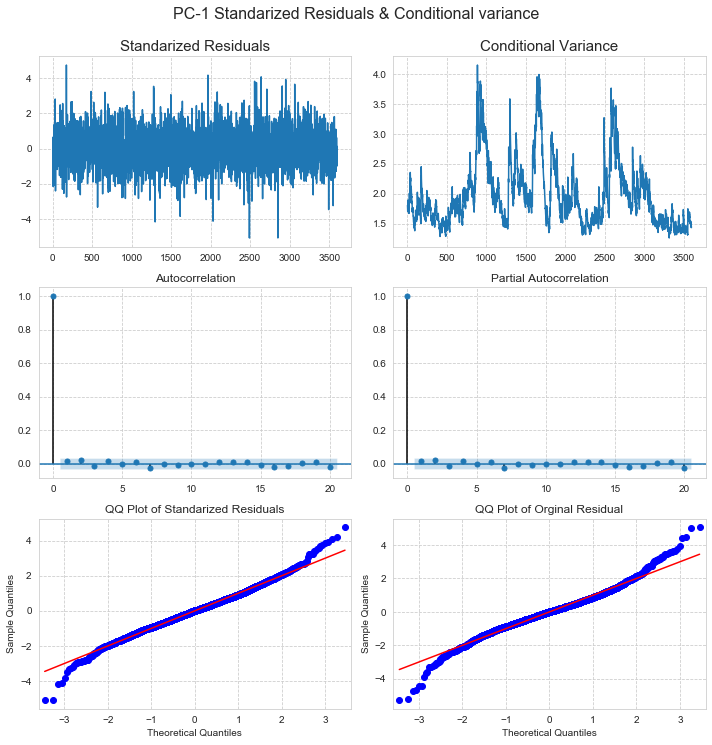

In [75]:
# Calculated standarized residuals
std_resid = res.resid / res.conditional_volatility
cond_variance = res.conditional_volatility/10
unit_var_resid = res.resid / res.resid.std()

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].plot(std_resid)
ax[0,0].set_title('Standarized Residuals', fontsize=15)
ax[0,0].grid(linestyle='--')
ax[0,1].plot(cond_variance)
ax[0,1].set_title('Conditional Variance', fontsize=15)
ax[0,1].grid(linestyle='--')
sm.graphics.tsa.plot_acf(std_resid**2, lags=20, ax=ax[1,0])
sm.graphics.tsa.plot_pacf(std_resid**2, lags=20, ax=ax[1,1])
sm.qqplot(std_resid, line='s', ax=ax[2,0])
ax[2,0].set_title('QQ Plot of Standarized Residuals')
sm.qqplot(unit_var_resid, line='s', ax=ax[2,1])
ax[2,1].set_title('QQ Plot of Orginal Residual')
fig.suptitle('PC-1 Standarized Residuals & Conditional variance', fontsize=16, y=1.03)
plt.tight_layout();

#### Standardized Residual PC2

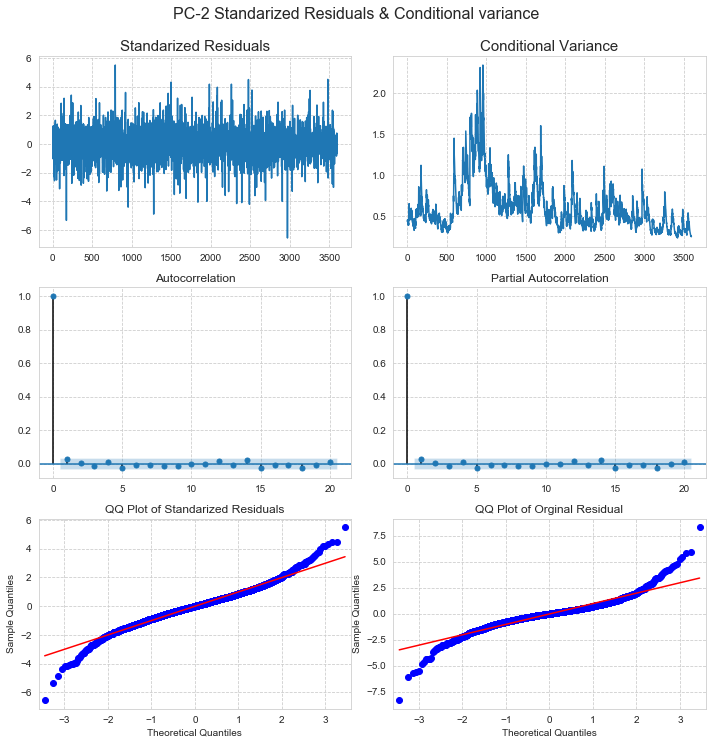

In [76]:
# Calculated standarized residuals
std_resid_2 = res_2.resid / res_2.conditional_volatility
cond_variance_2 = res_2.conditional_volatility/10
unit_var_resid_2 = res_2.resid / res_2.resid.std()

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].plot(std_resid_2)
ax[0,0].set_title('Standarized Residuals', fontsize=15)
ax[0,0].grid(linestyle='--')
ax[0,1].plot(cond_variance_2)
ax[0,1].set_title('Conditional Variance', fontsize=15)
ax[0,1].grid(linestyle='--')
sm.graphics.tsa.plot_acf(std_resid_2**2, lags=20, ax=ax[1,0])
sm.graphics.tsa.plot_pacf(std_resid_2**2, lags=20, ax=ax[1,1])
sm.qqplot(std_resid_2, line='s', ax=ax[2,0])
ax[2,0].set_title('QQ Plot of Standarized Residuals')
sm.qqplot(unit_var_resid_2, line='s', ax=ax[2,1])
ax[2,1].set_title('QQ Plot of Orginal Residual')
fig.suptitle('PC-2 Standarized Residuals & Conditional variance', fontsize=16, y=1.03)
plt.tight_layout();

#### Standardized Residual PC3

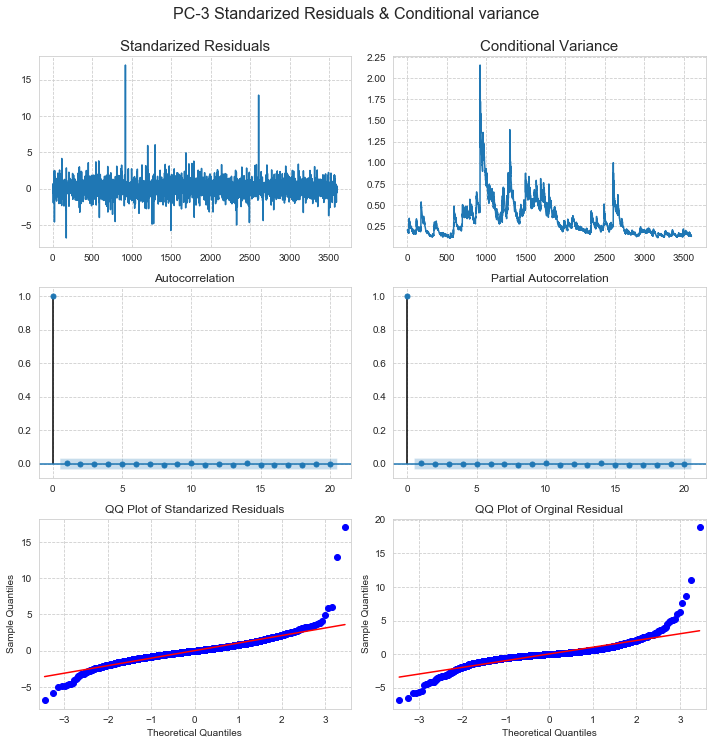

In [77]:
# Calculated standarized residuals
std_resid_3 = res_3.resid / res_3.conditional_volatility
cond_variance_3 = res_3.conditional_volatility/10
unit_var_resid_3 = res_3.resid / res_3.resid.std()

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].plot(std_resid_3)
ax[0,0].set_title('Standarized Residuals', fontsize=15)
ax[0,0].grid(linestyle='--')
ax[0,1].plot(cond_variance_3)
ax[0,1].set_title('Conditional Variance', fontsize=15)
ax[0,1].grid(linestyle='--')
sm.graphics.tsa.plot_acf(std_resid_3**2, lags=20, ax=ax[1,0])
sm.graphics.tsa.plot_pacf(std_resid_3**2, lags=20, ax=ax[1,1])
sm.qqplot(std_resid_3, line='s', ax=ax[2,0])
ax[2,0].set_title('QQ Plot of Standarized Residuals')
sm.qqplot(unit_var_resid_3, line='s', ax=ax[2,1])
ax[2,1].set_title('QQ Plot of Orginal Residual')
fig.suptitle('PC-3 Standarized Residuals & Conditional variance', fontsize=16, y=1.03)
plt.tight_layout();

### 16.4 Likelihood Ratio Test for Integrated Garch:


In [78]:
from scipy import stats

lr_unres = [862.1099, 5344.383, 7683.505]
lr_res = [848.0798, 5316.142, 7648.391]
pcs = ['PC_1','PC_2','PC_3']

LR_test_df=pd.DataFrame(data=[lr_unres,lr_res],columns=pcs,index=['LR unres','LR res']).T
LR_test_df['LR_stat'] = -2*np.log(LR_test_df['LR res'].div(LR_test_df['LR unres']))
LR_test_df['P_Value'] = 1 - stats.chi2.cdf(LR_test_df['LR_stat'] , 1)

np.round(LR_test_df,3)

,LR unres,LR res,LR_stat,P_Value
PC_1,862.110,848.080,0.033,0.856
PC_2,5344.383,5316.142,0.011,0.918
PC_3,7683.505,7648.391,0.009,0.924
